**Contents**

<font color=red>1. Part1: Tutorial</font>
 - 1.1 Dataset introduction
  - 1.1.1 Experiment environment
  - 1.1.2 Dataset files
  
  
- 1.2. Visualization
  - 1.2.1 CSI visualization in the time domain
      - 1.2.1.1 Visualization of one subcarrier's amplitude and phase of one link
      - 1.2.1.2 Visualization of amplitude and phase of all subcarriers
      - 1.2.1.3 Visualization of one subcarrier's amplitude of all links
      - 1.2.1.4 Comparison of background CSI and 12 BPM CSI
  - 1.2.2 CSI visualization in frequency domain
  - 1.2.3 Visualization of all ground-truth
  
  
- 1.3. Breath estimation pipeline
  - 1.3.1 Data loading
  - 1.3.2 Preprocessing
  - 1.3.3 Feature Extraction
  - 1.3.4 Peak Detection
  - 1.3.5 Result Evaluation

<font color=red>2. Part2: Task</font>
- 2.1 Task1: Controlled breath estimation (one person) (Points: 60)

- 2.2 Task2: Controlled breath estimation (two person) (Points: 10)

- 2.3 Task3: Varied breath estimation (one person) (Points: 10)

- 2.4 Advanced Task (Optional Bonus)

---
---

# Part I: Tutorial

In [1]:
# importing some libraries we need in this part
import scipy.io
import numpy as np
import os
from collections import defaultdict, Counter
import pandas as pd
from matplotlib import pyplot as plt
import pickle

## Dataset Introduction

The dataset contains CSI samples from one-user and two-user scenarios. Specifically, users have two different breathing modes: controlled mode and varied mode. In the controlled mode, each user maintains the same breathing rate during the experiment. While in the varied mode, the user's breathing rate either increases or decreases, or increases first and decreases to the initial rate.

### Experiment Enviroment

The released dataset are collected from an office (the layout is illustrated in the following picture).

![Experimental](Ex_Environment.jpg)

### Dataset Files


In [2]:
# Training set is released for constructing your solusion.

with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

print(trainset.keys())

dict_keys(['ex_name', 'CSI', 'CSI_timestamp', 'CSI_info', 'groundtruth'])


<font color=blue>**Description**:</font>
- 'ex_name': The names of all experiments, including experimental setup information (explained in the next block).
- 'CSI': A list of CSI series of all experiments.
- 'CSI_timestamp': A list of timestamp series corresponding to the CSI series.
- 'CSI_info': The basic information of the wifi device.
- 'groundtruth': The groundtruth of all experiments.

In [3]:
print('The experimental names:')
for experiment_name in trainset['ex_name']:
    print(experiment_name[:-4])

The experimental names:
breath_bpm12_ax200_cbw20_fs100_2x2_1_220928_163813
breath_bpm15_ax200_cbw20_fs100_2x2_1_220928_164837
breath_bpm20_ax200_cbw20_fs100_2x2_1_220928_165545
breath_bpm24-12_ax200_cbw20_fs100_2x2_1_220928_172548
breath_bpm12-24_ax200_cbw20_fs100_2x2_1_220928_171013
breath_bpm12-24-12_ax200_cbw20_fs100_2x2_1_220928_170213
breath_bpm15-20_multiperson_ax200_cbw20_fs100_2x2_1_220928_173606
breath_bpm15-24_multiperson_ax200_cbw20_fs100_2x2_1_220928_174240


<font color=blue>**Description**: ex_name </font>
1. One person, controlled:
    - breath_bpm12_ax200_cbw20_fs100_2x2_1_220928_163813: The experiment of **one** person with a **controlled** breath rate, <font color=red>12 BMP</font> (breath per minute).
    - breath_bpm15_ax200_cbw20_fs100_2x2_1_220928_164837: The experiment of **one** person with a **controlled** breath rate, <font color=red>15 BMP</font> (breath per minute).
    - breath_bpm20_ax200_cbw20_fs100_2x2_1_220928_165545: The experiment of **one** person with a **controlled** breath rate, <font color=red>20 BMP</font> (breath per minute).
2. One person, varied:
    - breath_bpm24-12_ax200_cbw20_fs100_2x2_1_220928_172548: The experiment of **one** person with **varied** breath rates decreased <font color=red>from 24 BMP to 12 BMP</font> (breath per minute).
    - breath_bpm12-24_ax200_cbw20_fs100_2x2_1_220928_171013: The experiment of **one** person with **varied** breath rates increased <font color=red>from 12 BMP to 24 BMP</font> (breath per minute).
    - breath_bpm12-24-12_ax200_cbw20_fs100_2x2_1_220928_170213: The experiment of **one** person with **varied** breath rates increased <font color=red>from 12 BMP to 24 BMP, and then back to 12 BMP</font>.
3. Two people, controlled:
    - breath_bpm15-20_multiperson_ax200_cbw20_fs100_2x2_1_220928_173606: The experiment of **two** people with **controlled** breath rates, <font color=red>15 BMP and 20 BMP</font> respectively.
    - breath_bpm15-24_multiperson_ax200_cbw20_fs100_2x2_1_220928_174240: The experiment of **two** people with **controlled** breath rates, <font color=red>15 BMP and 24 BMP</font> respectively.

In [4]:
print('Basic information of wifi device:')
print('carrier_frequency: ', trainset['CSI_info']['carrier_frequency'])
print('subcarrier_bandwidth: ', trainset['CSI_info']['subcarrier_bandwidth'])
print('The number of subcarriers: ',
      len(trainset['CSI_info']['subcarrier_index'][0]))

Basic information of wifi device:
carrier_frequency:  [[5.57e+09]]
subcarrier_bandwidth:  [[78125]]
The number of subcarriers:  245


<font color =blue>**Description:** CSI_info</font>

The [AX200](https://www.intel.com/content/www/us/en/products/sku/189347/intel-wifi-6-ax200-gig/specifications.html) WiFi device with WiFi 6 (IEEE 802.11ax) protocol was used in these experiments.
The wifi channel's center frequency is **5.57** GHz, with a bandwidth of 20 MHz.
There are a total of **245** subcarriers with the subcarrier spacing of **78.125** kHz.

If you want to learn more about WiFi 6, please see the following online resources: 
- https://support.huawei.com/enterprise/en/doc/EDOC1100102755
- https://www.litepoint.com/blog/wi-fi-6-vs-wi-fi-5-key-changes-to-the-rf-physical-layer/
- https://www.techspot.com/article/1769-wi-fi-6-explained/
- https://standards.ieee.org/ieee/802.11ax/7180/ 

In [5]:
CSI = trainset['CSI']
CSI_timestamp = trainset['CSI_timestamp']
print('The number of CSI series: ', len(CSI))
print('The number of CSI timestamp series: ', len(CSI_timestamp))
print('\n')
print('The data shape of the first CSI series: ', CSI[0].shape)
print('The data shape of the first CSI timestamp series: ',
      CSI_timestamp[0].shape)

The number of CSI series:  8
The number of CSI timestamp series:  8


The data shape of the first CSI series:  (6600, 245, 2, 2)
The data shape of the first CSI timestamp series:  (6600,)


<font color =blue>**Description:** CSI and CSI_timestamp</font> 

As shown above, the total number of CSI series and CSI timestamp series are both eight, i.e., one experiment has one CSI series and one CSI timestamp series. Furthermore, the type of each CSI series is numpy array with shape of (number_of_samples, number_of_subcarriers, number_of_transmit_antennas, number_of_receiving_antennas). And the element of each CSI timestamp series is represent the time that the corresponding CSI sample is captured. In the above example, the first CSI series has 6600 CSI sample, and each sample has 245 subcarriers from two Tx (Transmission Antennas) to two Rx (Receiving Antennas).

In [6]:
groundtruth = trainset['groundtruth']
print("The number of groundtruth series: ", len(groundtruth))
print("The shape of the first groundtruth series: ", groundtruth[0].shape)

The number of groundtruth series:  8
The shape of the first groundtruth series:  (66,)


<font color =blue>**Description:** groundtruth</font> 

We have eight ground-truth series in the dataset, whereby each experiment has one ground-truth series. Specifically, the ground-truth is captured by using the [OpenSignals respairation analysis device](https://www.pluxbiosignals.com/collections/opensignals/products/respiration-pzt-rip-analysis-add-on) and showing the breath rate every second with the unit of BMP (breath per minute). Based on the illustrated information of the first experiment, the shape of the ground-truth series is (66,) which means there are 66 recorded breath rates. Thus, the first experiment lasts for 66 seconds. By the way, since the sampling frequency of the CSI series is 100 Hz, the number of CSI samples in the first CSI series should be 6600 (refer to the previous block).

---
## Visualization

In this section, we will visualize the CSI series by using the first CSI series in the dataset as an example. The illustrations will be conducted in both the time domain and frequency domain. The entire ground-truth series will be represented in order to help you better comprehend what happened in these experiments. 

### CSI visualization in the time domain

In [7]:
CSI_amplitude = np.abs(CSI[0])  # the amplitude of CSI
CSI_phase = np.angle(CSI[0])    # the phase of CSI
print("the name of the first experiment: ", trainset['ex_name'][0][:-4])

the name of the first experiment:  breath_bpm12_ax200_cbw20_fs100_2x2_1_220928_163813


The CSI samples are complex matrices, we first transform the complex value into amplitude and phase.

#### Visualization of one subcarrier's amplitude and phase of one link 

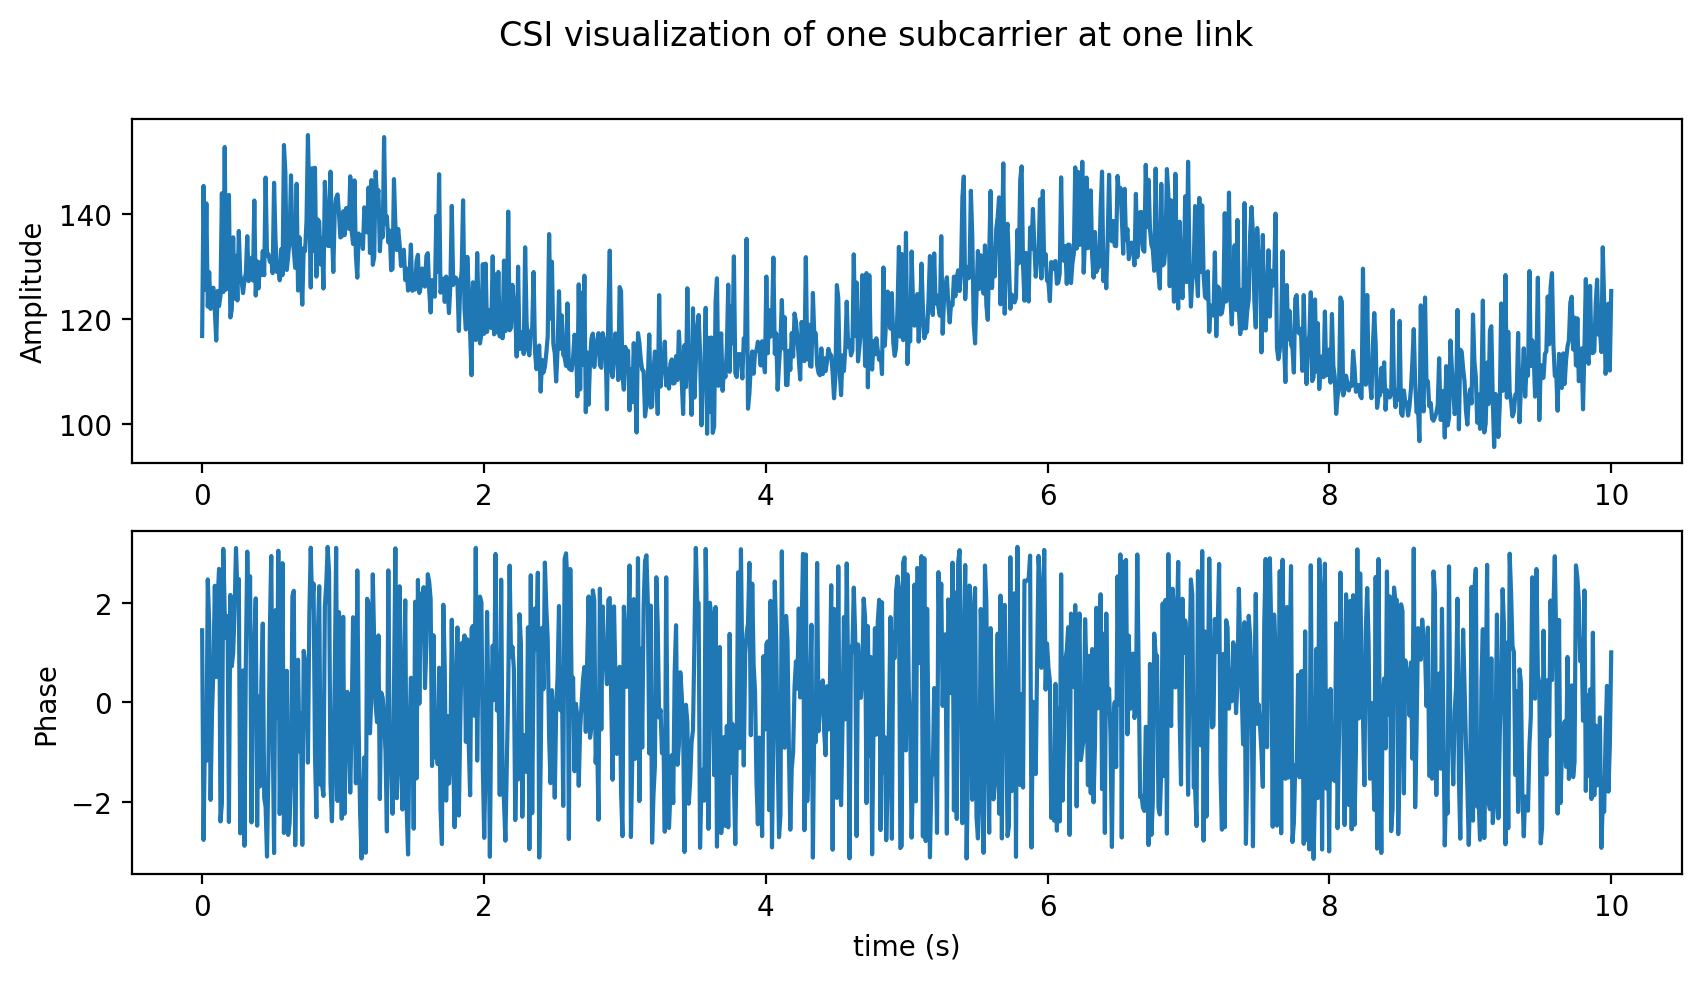

In [8]:
selected_Rx = 1  # the selected of Rx: 0 or 1
selected_Tx = 1  # the selected of Tx: 0 or 1
selected_subcarrier = [10, 11]  # the selected subcarriers from 245 subcarriers
time_range = [0, 1000]  # the visualized time range
visualize_amp = CSI_amplitude[time_range[0]:time_range[1],
                              selected_subcarrier[0]:selected_subcarrier[1],
                              selected_Rx, selected_Tx]
visualize_pha = CSI_phase[time_range[0]:time_range[1],
                          selected_subcarrier[0]:selected_subcarrier[1],
                          selected_Rx, selected_Tx]
# Plot chart

time_axis = np.linspace(time_range[0], time_range[1], num=time_range[1])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), dpi=200)
fig.suptitle('CSI visualization of one subcarrier at one link ')

ax1.plot(
    time_axis / 100,
    visualize_amp,
)
ax1.set_ylabel('Amplitude')

ax2.plot(
    time_axis / 100,
    visualize_pha,
)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Phase')

plt.show()

<font color =blue>**Analysis:**</font>

As shown in the above figure, the amplitude has a significant periodic pattern, that is, there are two peaks in ten seconds. In this way, one peak corresponds to one breath, and there will be 12 breath cycles in one minute. The first experiment is in the controlled mode, where one person maintains a 12 BPM breath rate all the time. Hence, the periodic pattern of the amplitude is related to the breathing rate. As for the phase, it does not show a clear periodic pattern as the amplitude. If we want to adopt the phase, we need to preprocess it by using phase cleaning method in [WiDance](https://dl.acm.org/doi/abs/10.1145/3025453.3025678).

#### Visualization of amplitude and phase of all subcarriers

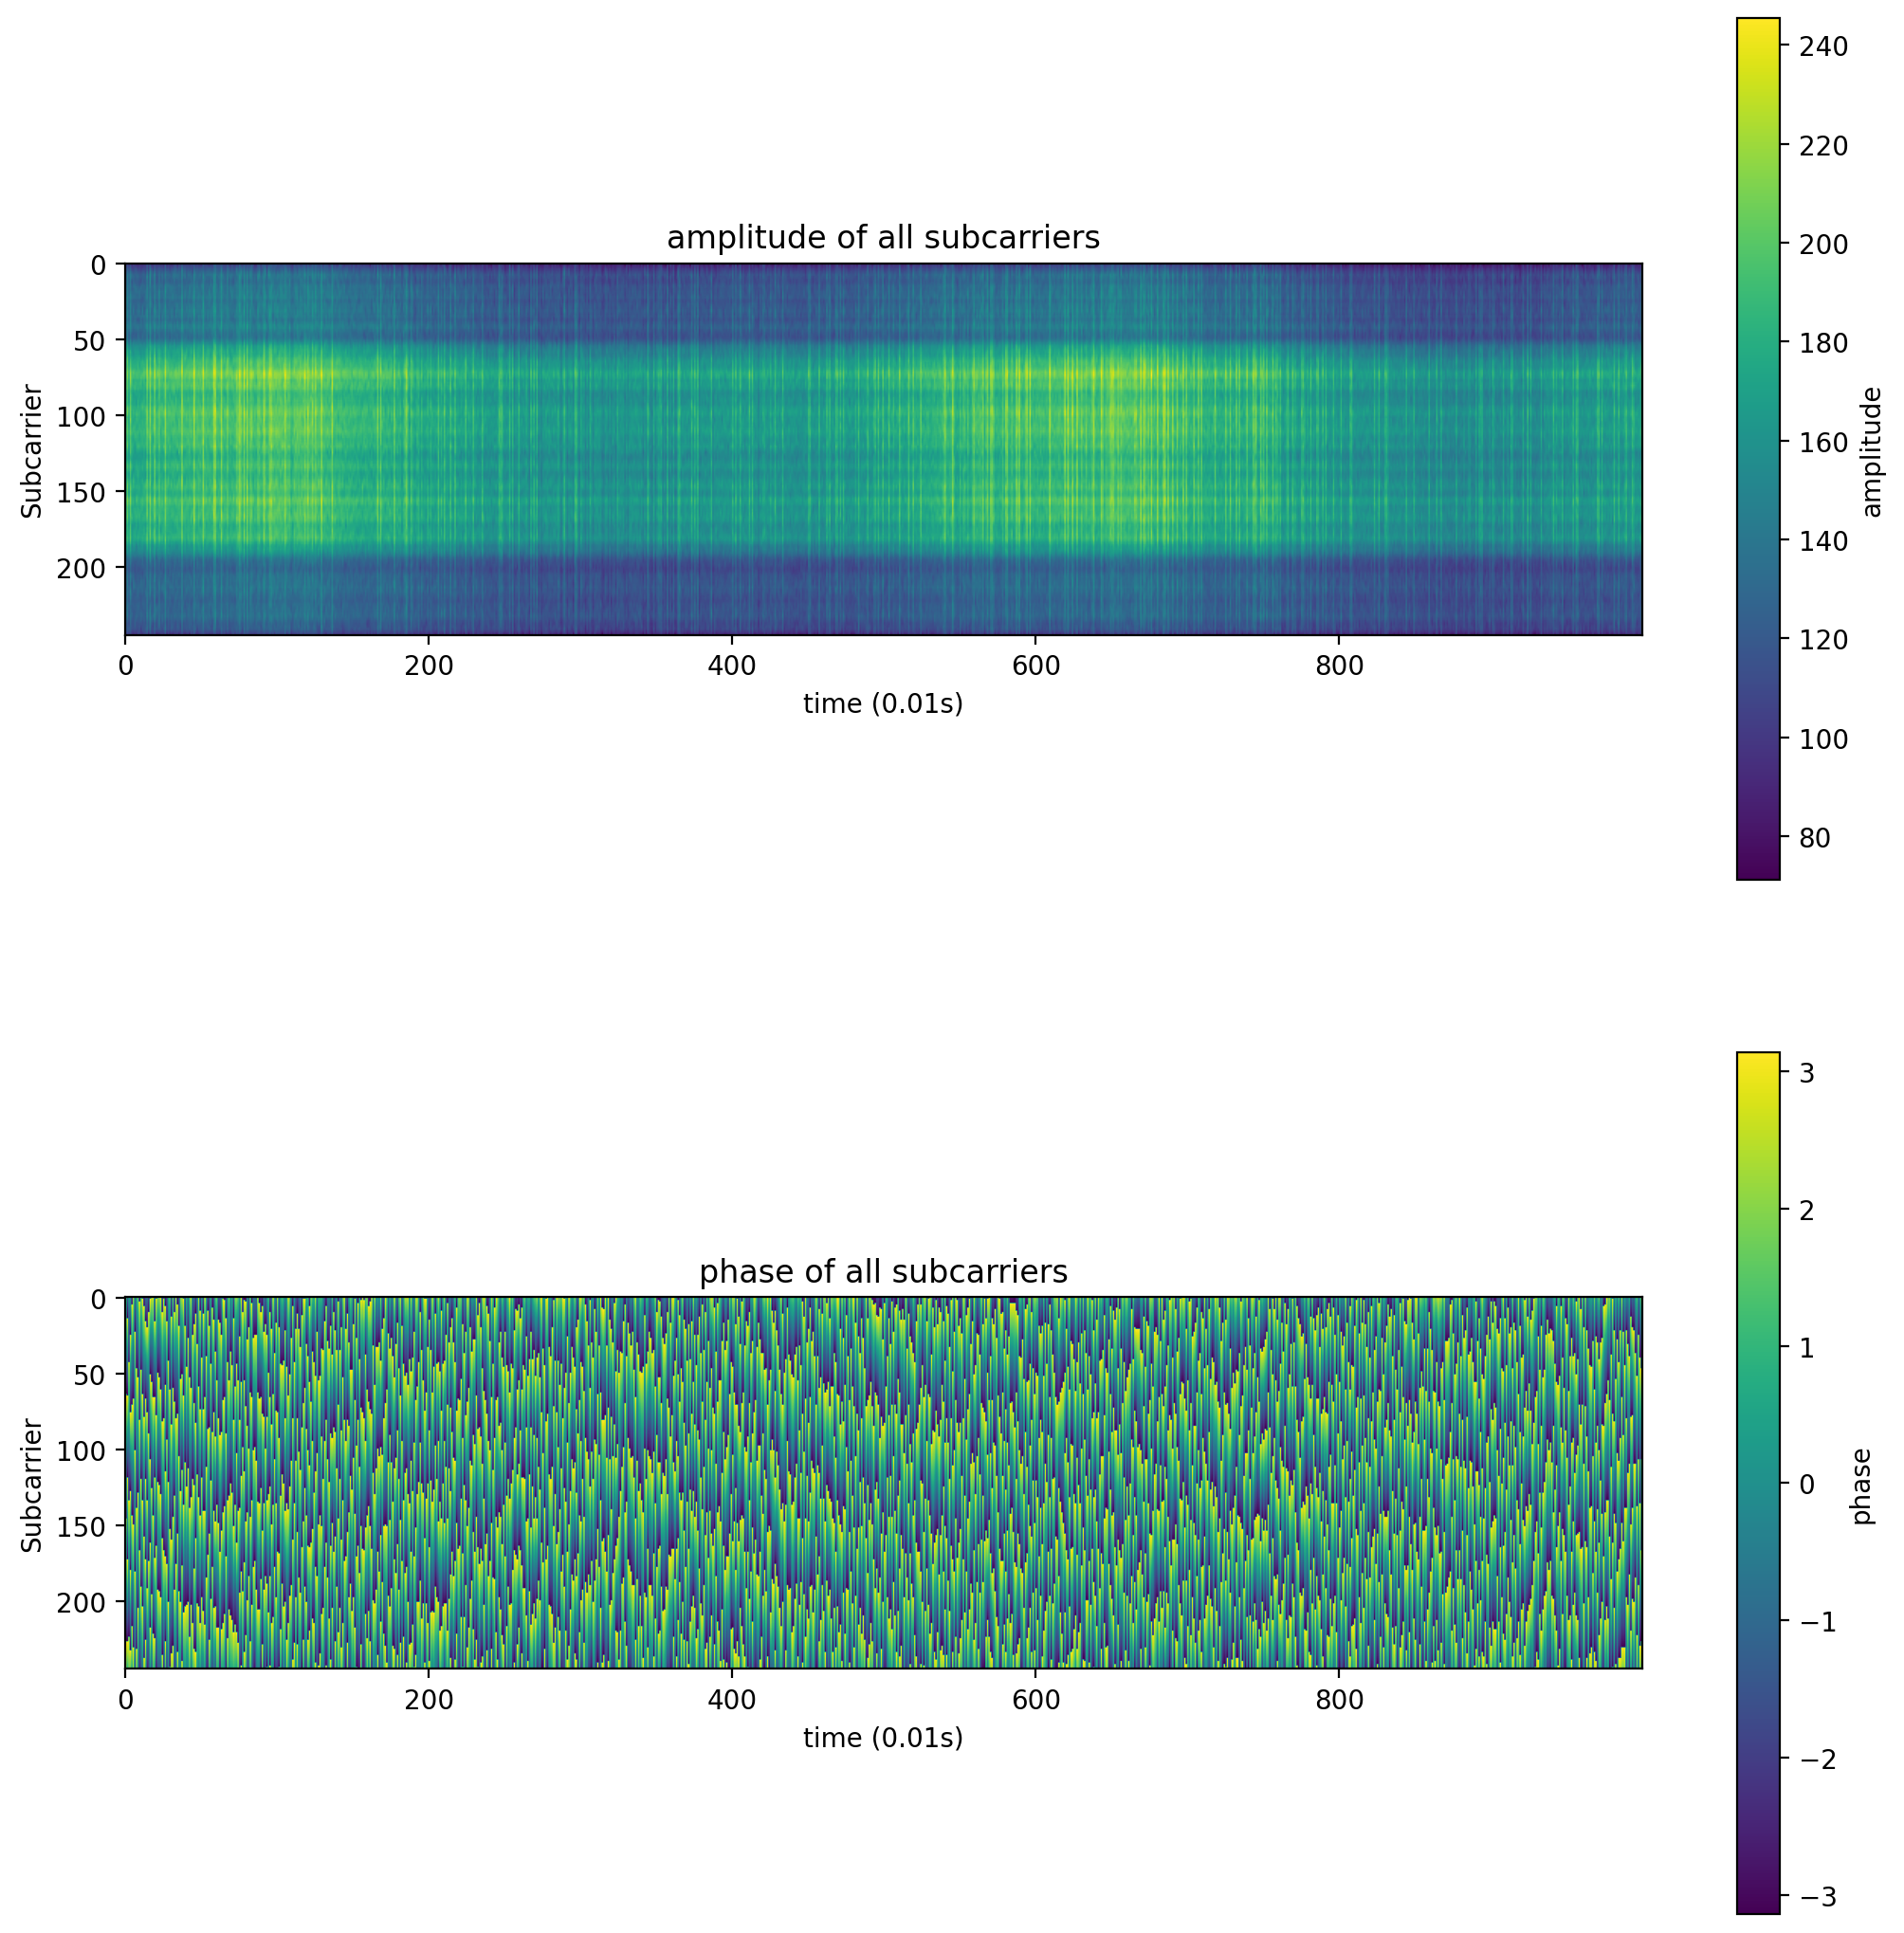

In [9]:
visualize_amp_allsubcarriers = CSI_amplitude[time_range[0]:time_range[1], :,
                                             selected_Rx, selected_Tx]
visualize_pha_allsubcarriers = CSI_phase[time_range[0]:time_range[1], :,
                                         selected_Rx, selected_Tx]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), dpi=200)
plt.subplots_adjust(left=0.0, bottom=0.0, top=2, right=1)

im1 = ax1.imshow(visualize_amp_allsubcarriers.transpose(1, 0))
ax1.set_title('amplitude of all subcarriers')
ax1.set_xlabel('time (0.01s)')
ax1.set_ylabel('Subcarrier')
fig.colorbar(im1, ax=ax1, label='amplitude')

im2 = ax2.imshow(visualize_pha_allsubcarriers.transpose(1, 0))
ax2.set_title('phase of all subcarriers')
ax2.set_xlabel('time (0.01s)')
ax2.set_ylabel('Subcarrier')
fig.colorbar(im2, ax=ax2, label='phase')

plt.show()

<font color =blue>**Analysis:**</font>

For one CSI series, we have four links, i.e., 2 (Tx) x 2 (Rx) = 4 (Links). For each link, the CSI time series can be viewed as a complex matrix with shape as the_number_of_subcarriers x the_number_of_samples. And we can show this complex matrix in two parts, amplitude and phase, as above.

#### Visualization of one subcarrier's amplitude of all links

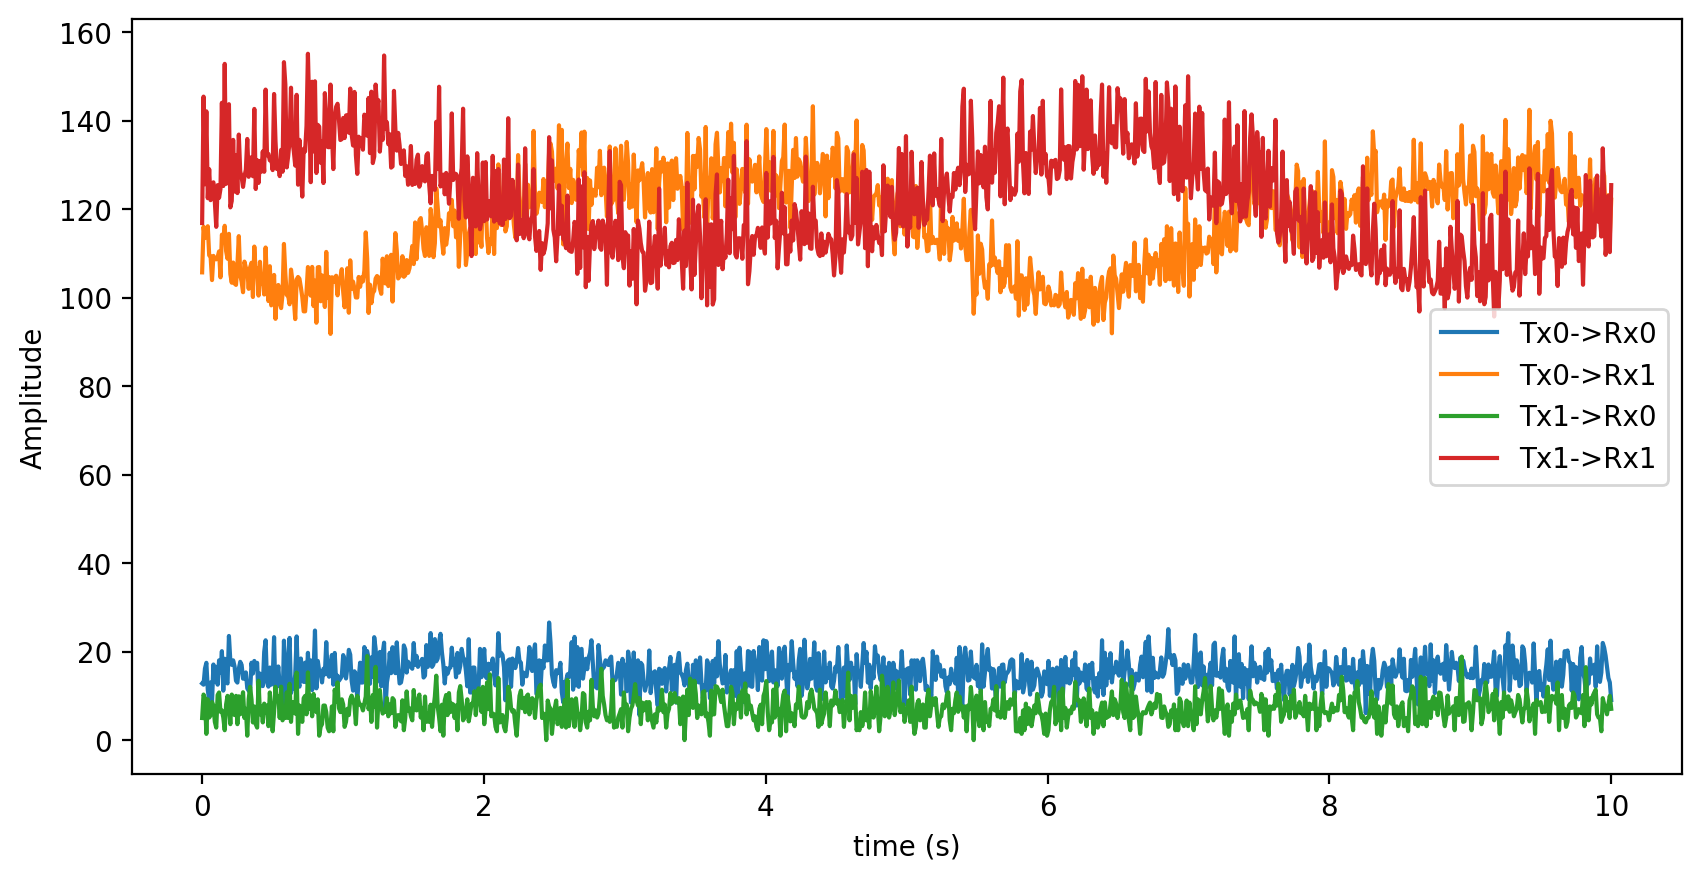

In [10]:
selected_subcarrier = 10  # the selected subcarriers from 245 subcarriers
time_range = [0, 1000]  # the visualized time range
visualize_amp1 = CSI_amplitude[time_range[0]:time_range[1],
                               selected_subcarrier, 0, 0]
visualize_amp2 = CSI_amplitude[time_range[0]:time_range[1],
                               selected_subcarrier, 0, 1]
visualize_amp3 = CSI_amplitude[time_range[0]:time_range[1],
                               selected_subcarrier, 1, 0]
visualize_amp4 = CSI_amplitude[time_range[0]:time_range[1],
                               selected_subcarrier, 1, 1]

time_axis = np.linspace(time_range[0], time_range[1], num=time_range[1])

plt.figure(figsize=(10, 5), dpi=200)

plt.plot(time_axis / 100, visualize_amp1, label='Tx0->Rx0')
plt.plot(time_axis / 100, visualize_amp2, label='Tx0->Rx1')
plt.plot(time_axis / 100, visualize_amp3, label='Tx1->Rx0')
plt.plot(time_axis / 100, visualize_amp4, label='Tx1->Rx1')
plt.ylabel('Amplitude')
plt.xlabel('time (s)')
plt.legend(loc='best')

plt.show()

<font color =blue>**Analysis:**</font>

As demonstrated above, the CSI series of some links (Tx0->Rx1, Tx1->Rx1) show a significant periodic pattern corresponding to the user's breath, while that of others (Tx0->Rx0, Tx1->Rx0) don't. Hence, it is important to select appropriate links to estimate the user's breath rate.

#### Comparison of background CSI and 12 BPM CSI

In this subsection, a brief comparison of the background CSI series and the 12 BPM CSI series is illustrated. Specifically, the background CSI series is collected from the office when no one is in there. And we will show the amplitudes of one subcarrier at one link in these two CSI series.

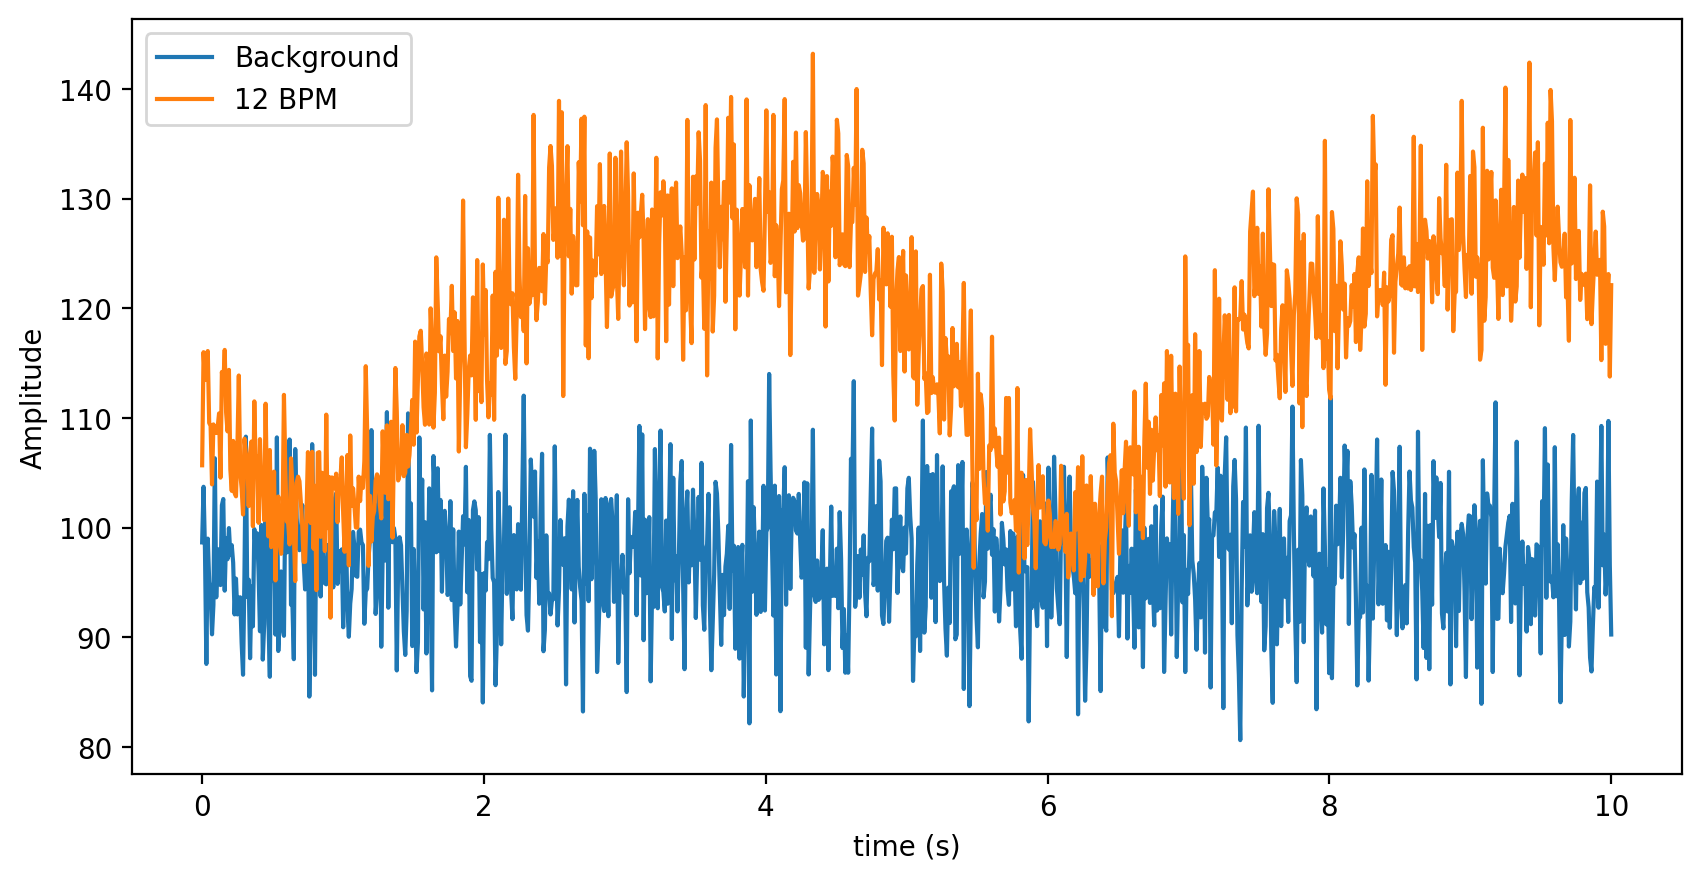

In [11]:
# 1. loading the background CSI file


# compare two tuples. Python3 doesn't have the cmp() which is in python2
def cmp(a, b):
    return (a > b) - (a < b)


# loading
background_mat = scipy.io.loadmat('empty.mat')
background_data = background_mat['save_experiment'][0]
background_CSI = []
for i in range(len(background_data)):
    sample = background_data[i]
    temp = sample[5].shape
    if cmp(temp, (245, 2, 2)) != 0:
        continue
    background_CSI.append(sample[5])
background_CSI = np.stack(background_CSI, axis=0)

# 2. Comparison
background_CSI_amp = np.abs(
    background_CSI)  # calculate the amplitude of the background CSI series

selected_subcarrier = 10  # the selected subcarriers from 245 subcarriers
time_range = [0, 1000]  # the visualized time range
background_CSI_amp = background_CSI_amp[0:time_range[1], selected_subcarrier,
                                        0, 0]
BPM12_CSI_amp = CSI_amplitude[time_range[0]:time_range[1], selected_subcarrier,
                              0, 1]

time_axis = np.linspace(time_range[0], time_range[1], num=time_range[1])

plt.figure(figsize=(10, 5), dpi=200)
plt.plot(time_axis / 100, background_CSI_amp, label='Background')
plt.plot(time_axis / 100, BPM12_CSI_amp, label='12 BPM')

plt.ylabel('Amplitude')
plt.xlabel('time (s)')
plt.legend(loc='best')

plt.show()

<font color =blue>**Analysis:**</font>

The amplitude of the 12 BPM CSI series displays a periodic pattern, while that of the background CSI series resembles Gaussian noise, as demonstrated in the above picture.
This situation makes sense given that no one is in the office when the background CSI is being collected. 

### CSI visualization in frequency domain

/Users/zx/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


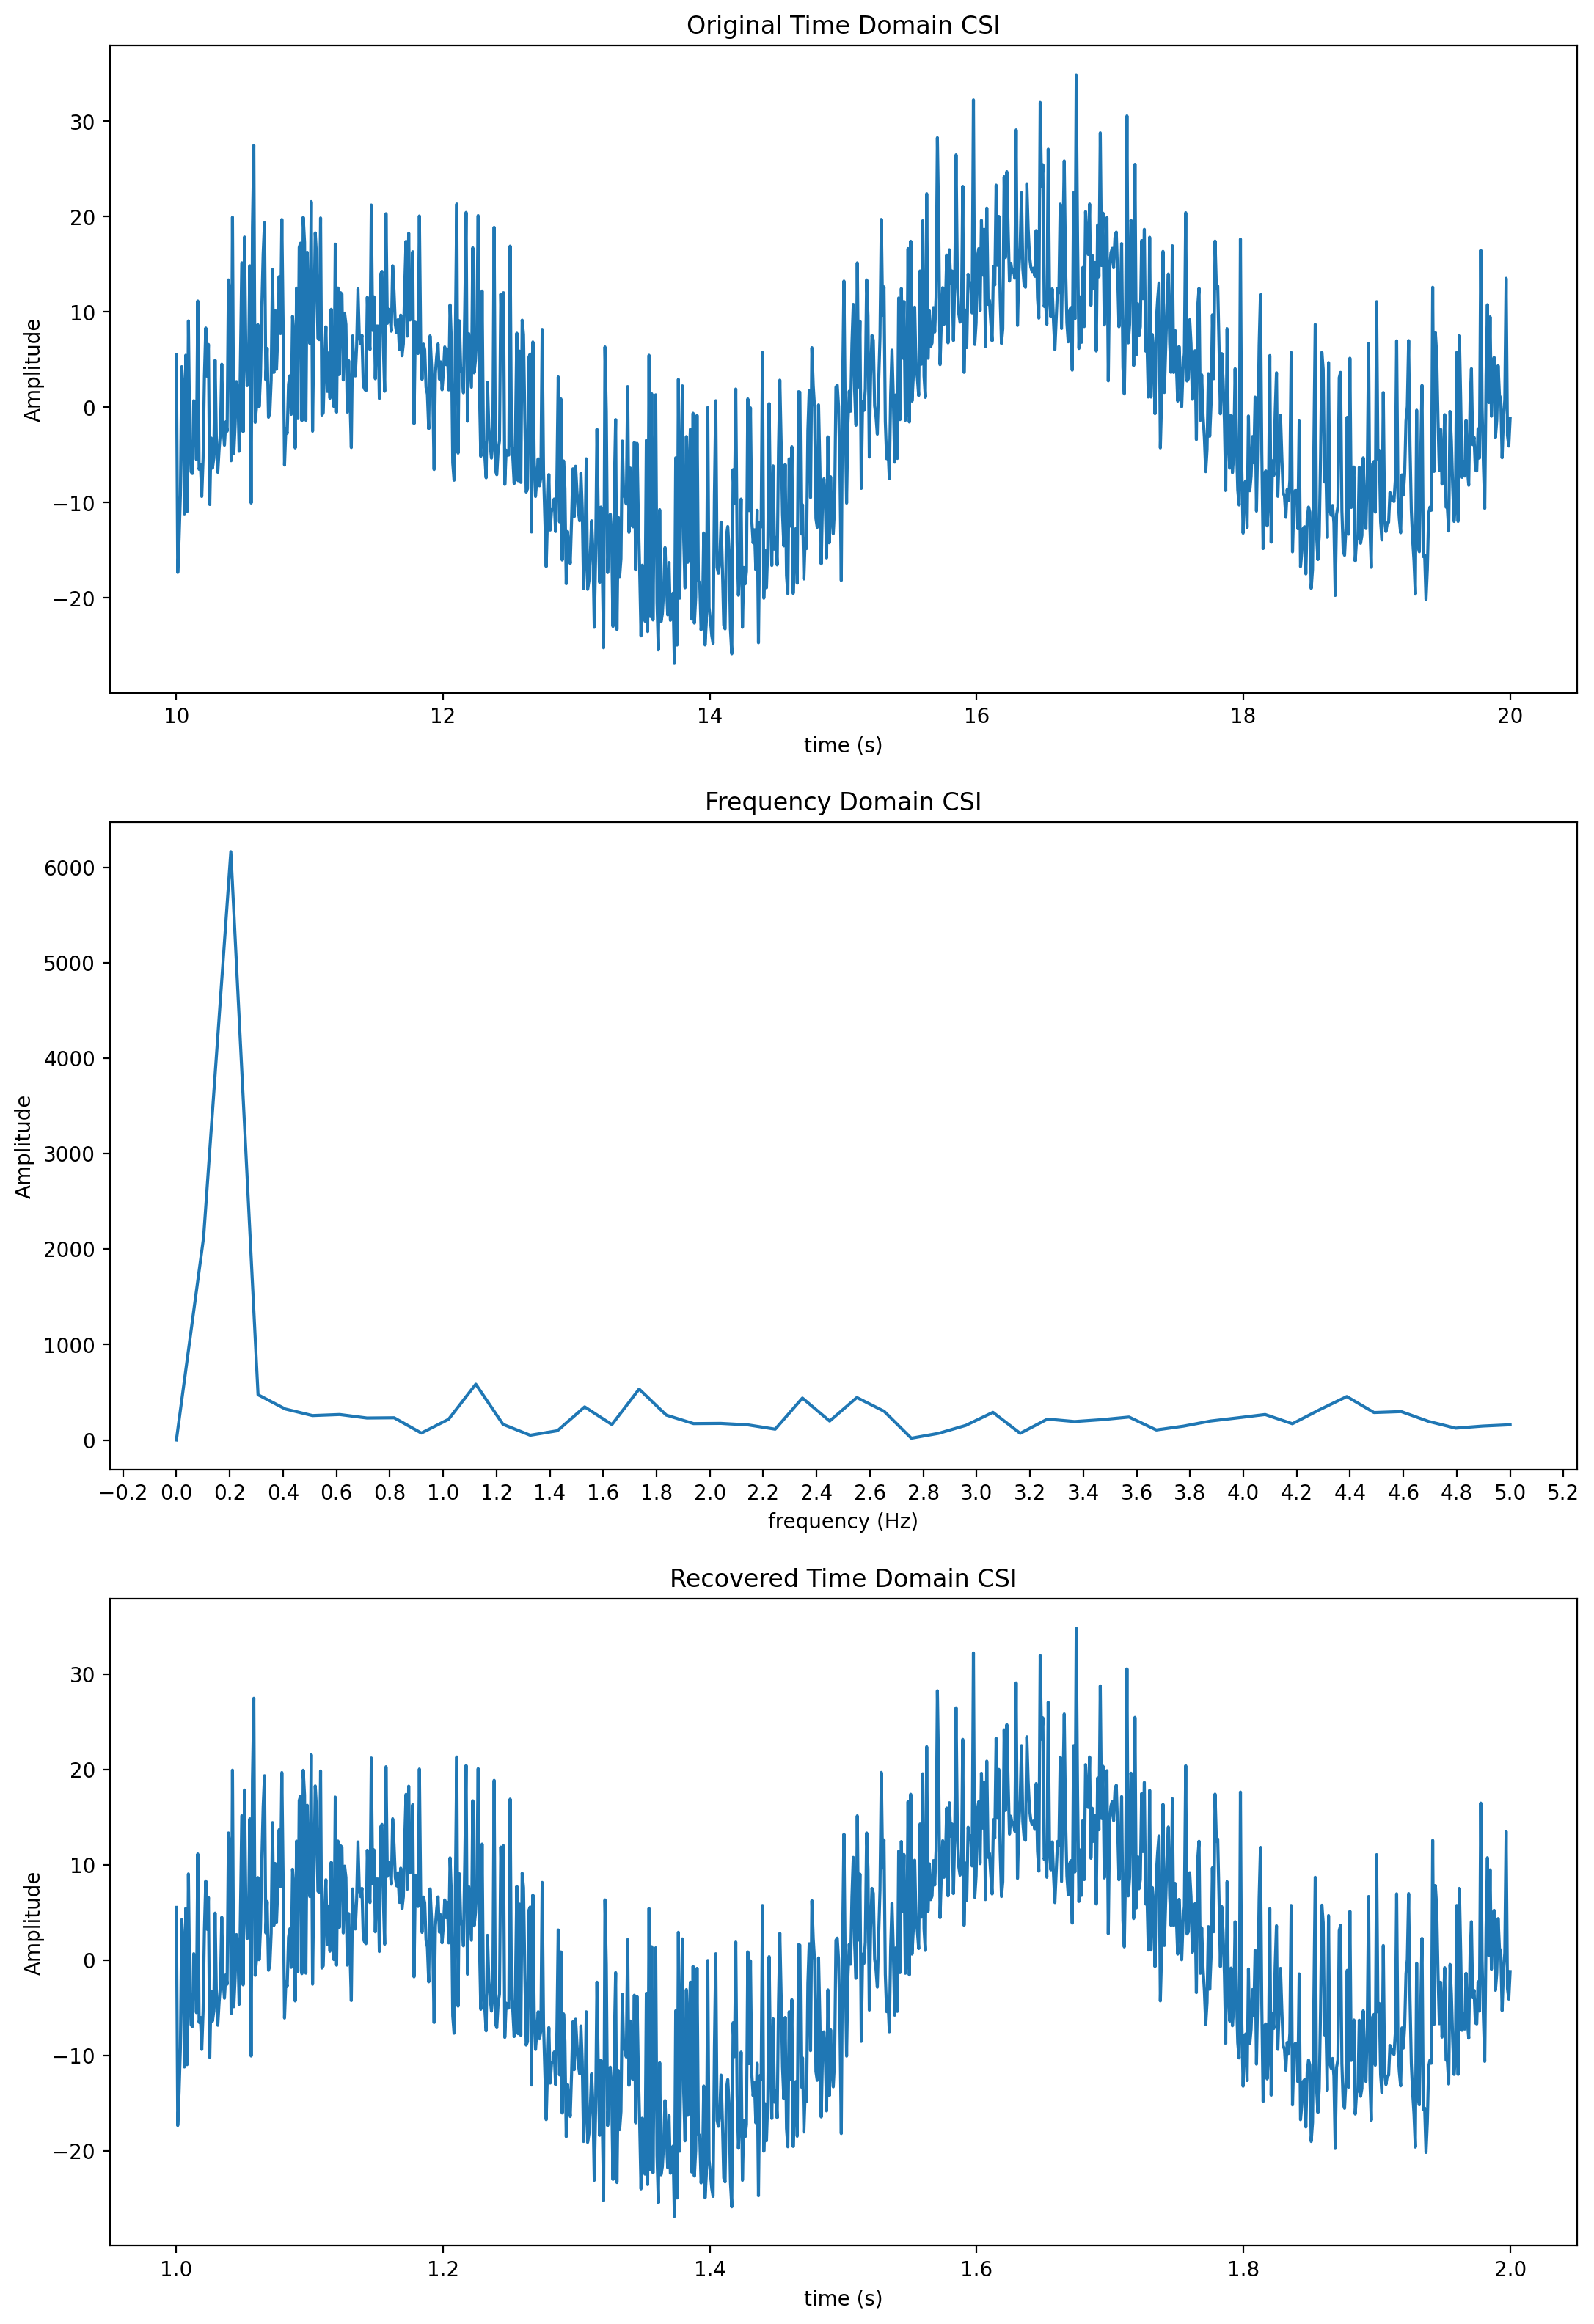

In [12]:
import matplotlib.ticker as ticker  # for axis locator setting
from scipy.fft import fft, fftfreq, ifft
# import the fast Fourier transformation
# using FFT on the CSI amplitude: transfer the time domain signal to freqency domain

# seleting one link, one subcrrier to show the fft
time_range = [1000, 2000]  # the visualized time range
num_samples = time_range[1] - time_range[0]  # the number of samples
sampling_rate = 100  # the CSI sampling rate: 100 Hz
selected_Rx = 1  # the selected of Rx: 0 or 1
selected_Tx = 1  # the selected of Tx: 0 or 1
selected_subcarrier = 15  # the selected subcarriers from 245 subcarriers

seleted_CSI_amp = CSI_amplitude[time_range[0]:time_range[1],
                                selected_subcarrier, selected_Rx, selected_Tx]

# subtracting the mean value
seleted_CSI_amp = seleted_CSI_amp - np.mean(seleted_CSI_amp)

# calculating the fft
fft_CSI = fft(seleted_CSI_amp)

# recovering the original CSI amplitude from the fft version
recover_CSI = ifft(fft_CSI)

# visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5), dpi=200)
plt.subplots_adjust(left=0.0, bottom=0.0, top=3, right=1)

time_axis = np.linspace(time_range[0], time_range[1], num=num_samples)
ax1.plot(
    time_axis / 100,
    seleted_CSI_amp,
)
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('time (s)')
ax1.set_title("Original Time Domain CSI")

ax2.plot(np.linspace(0, 5, 50), np.abs(fft_CSI[:50]))
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
# max_value = np.max(np.abs(fft_CSI[:50]))
# arg_max = np.argmax(np.abs(fft_CSI[:50]))/10
# ax2.plot(arg_max,max_value, 'o')
# ax2.text(arg_max+0.1,max_value, '('+ str(arg_max) + ', '+ str(max_value) + ')' )
ax2.set_title("Frequency Domain CSI")

ax3.plot(time_axis / 1000, recover_CSI)
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Amplitude')
ax3.set_title("Recovered Time Domain CSI")

plt.show()

<font color =blue>**Analysis:**</font>

The above figures from top to down are the amplitude of the CSI series in the time domain, the FFT (Fast Fourier Transformation) of this series (i.e., the frequency domain version), and the recovered time domain version from the frequency domain version.

### Visualization of all ground-truth

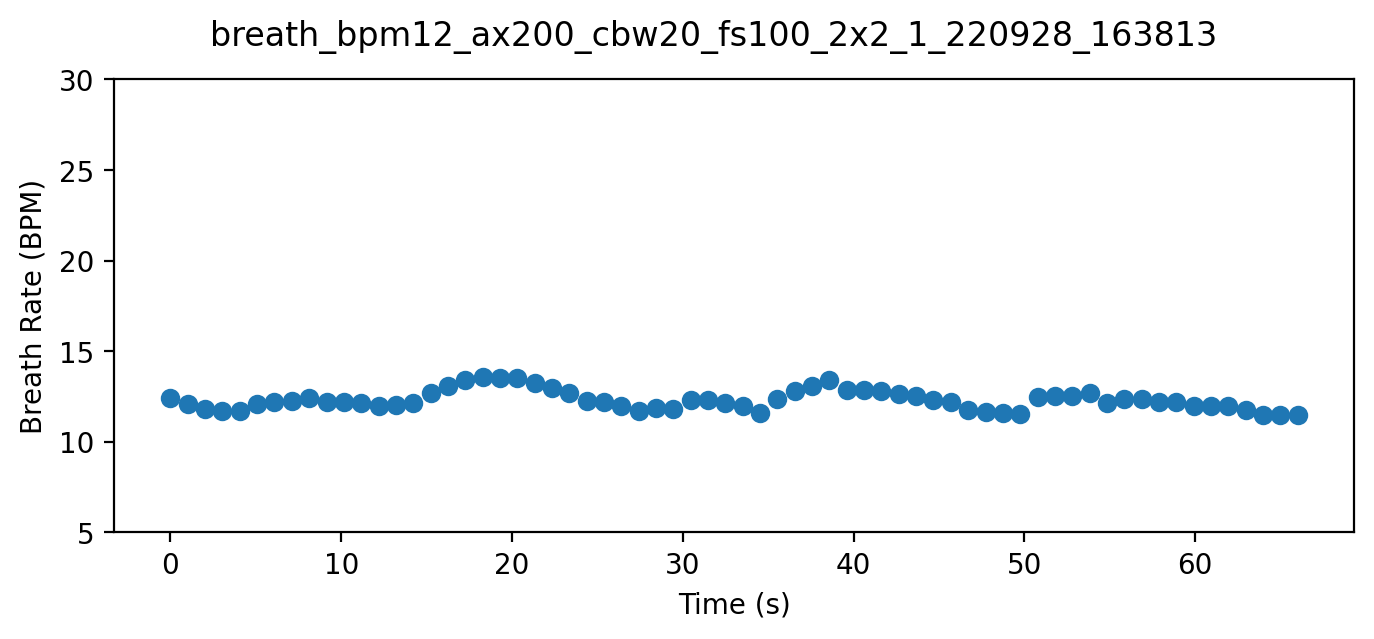

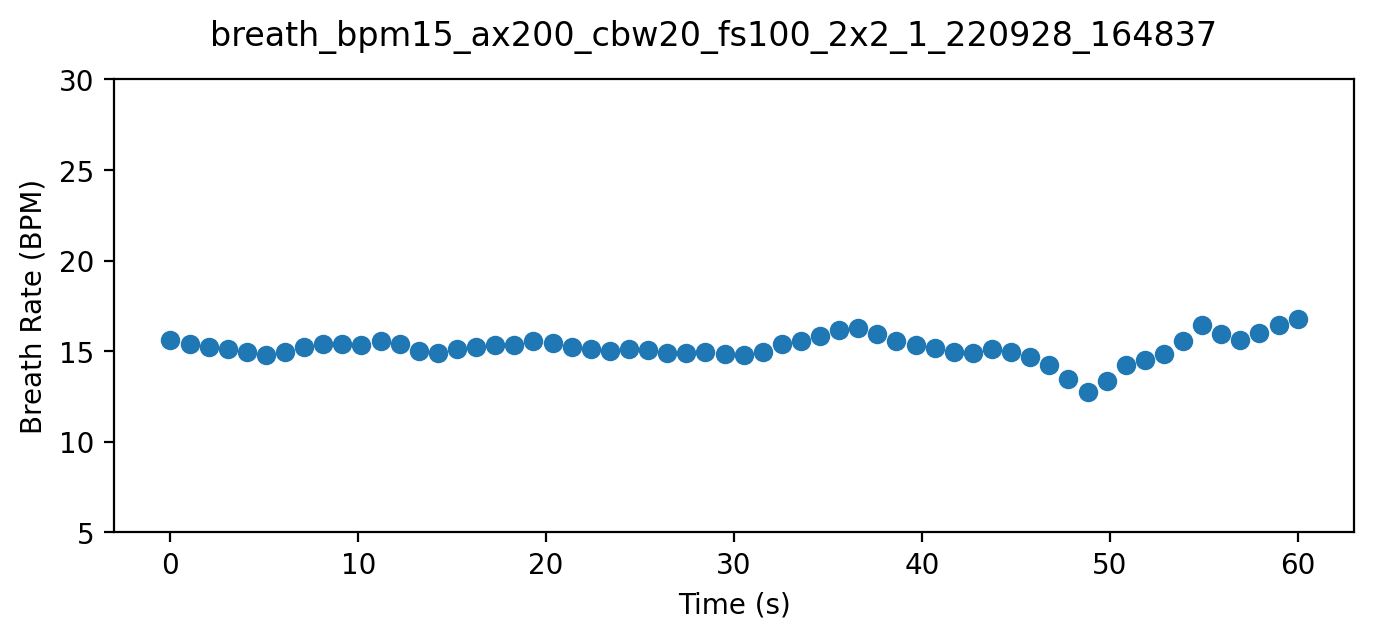

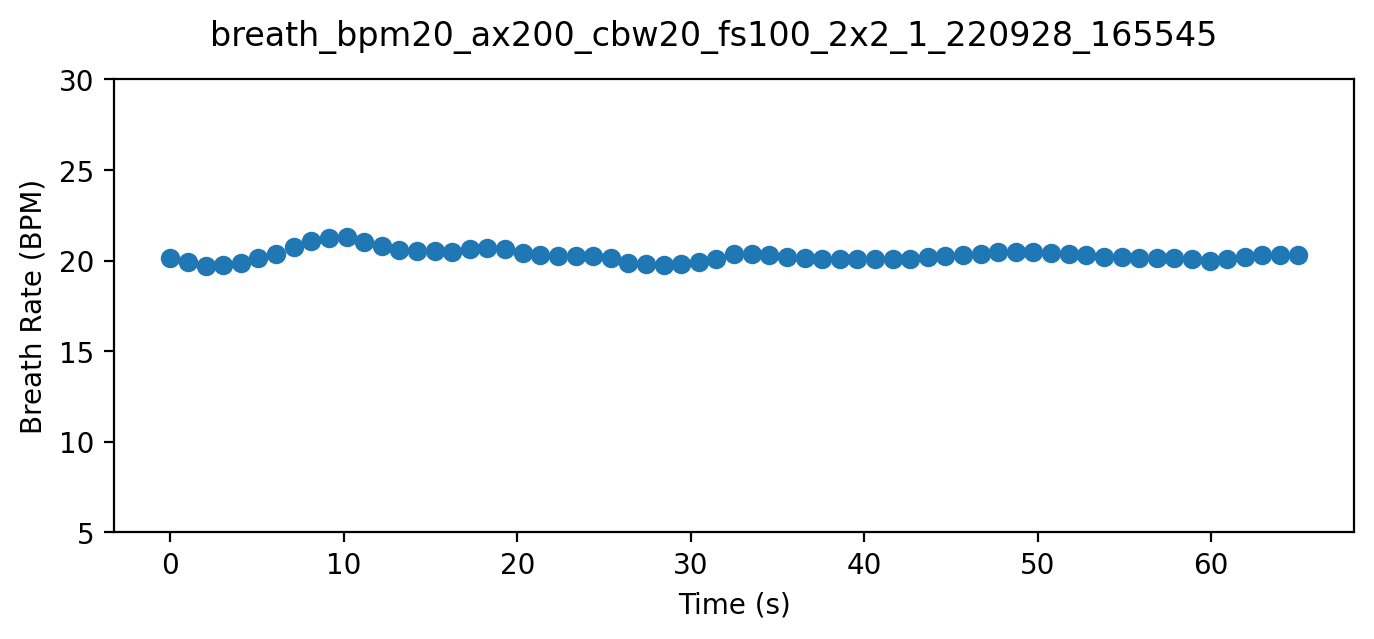

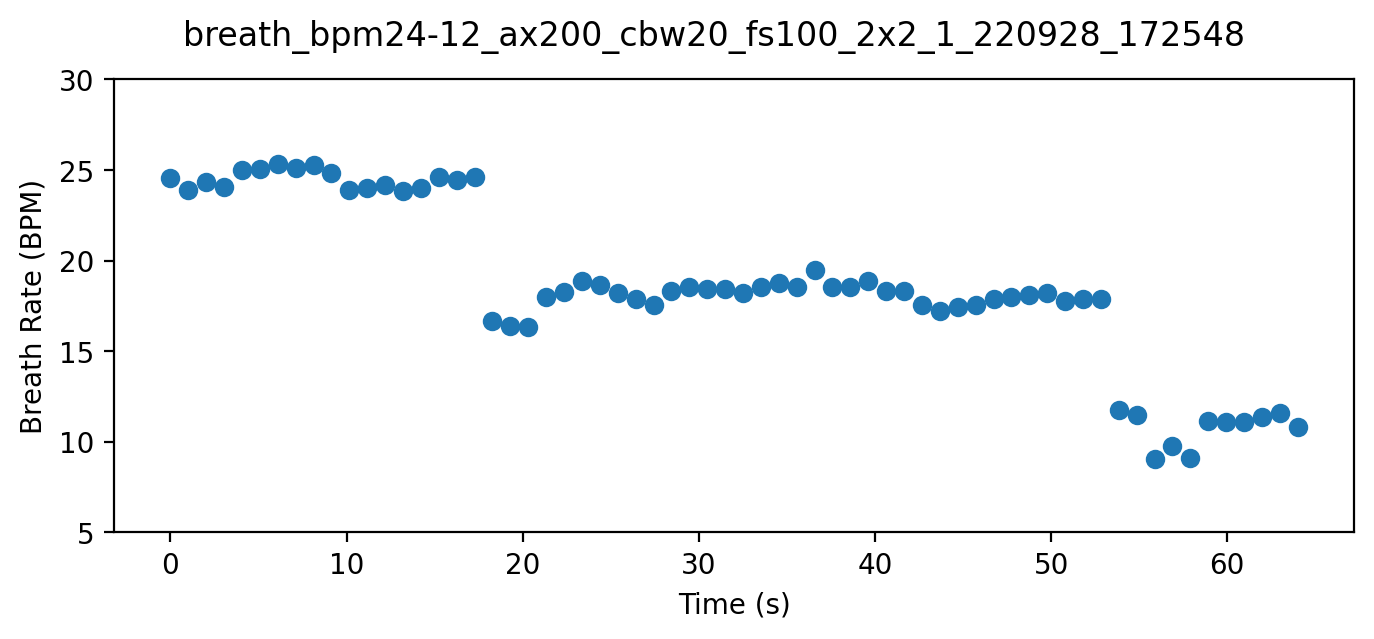

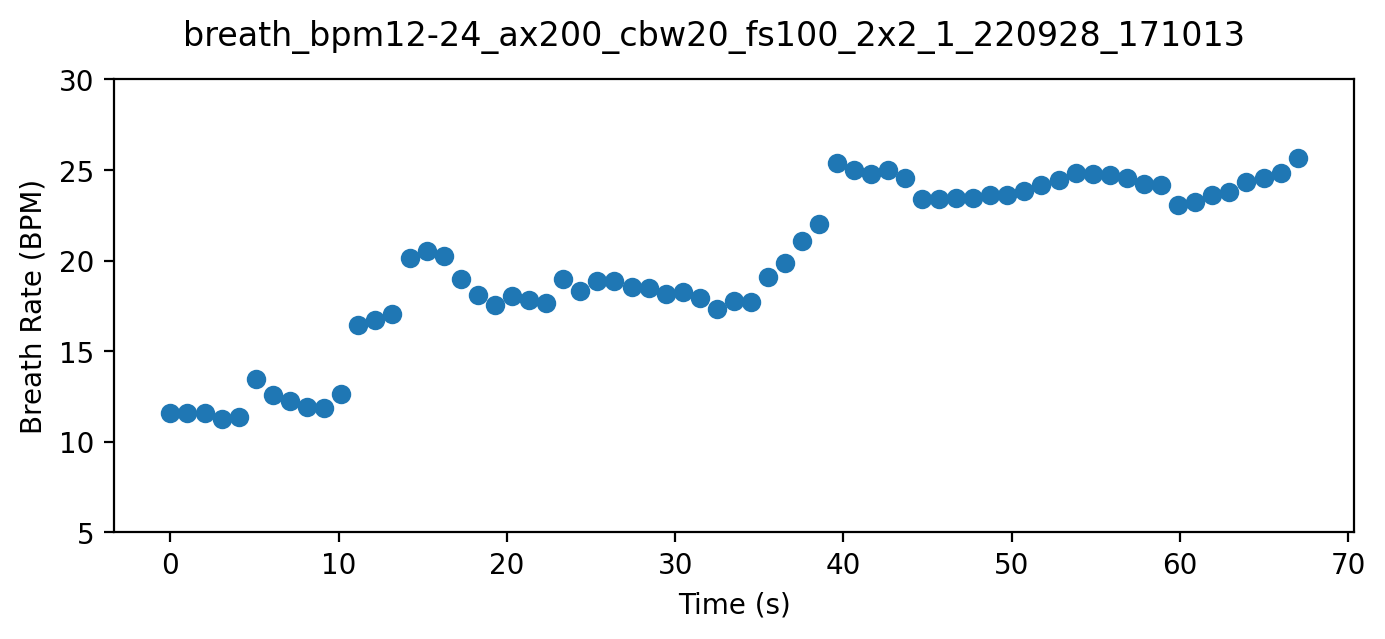

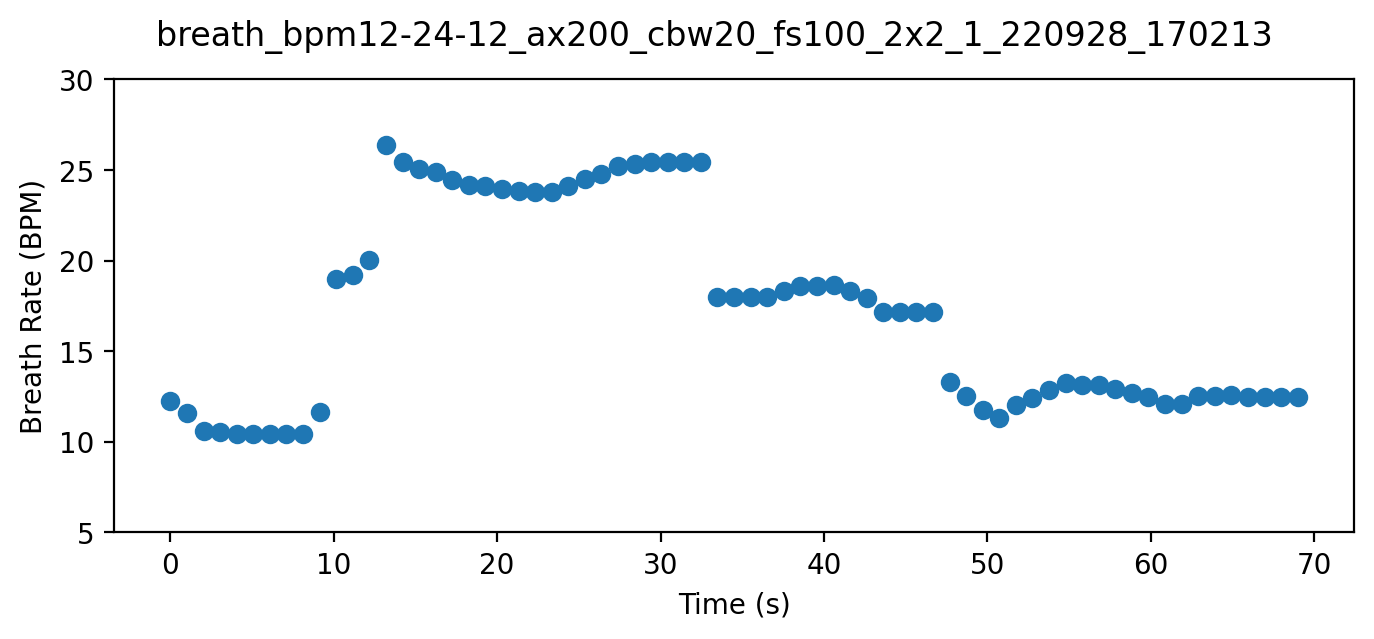

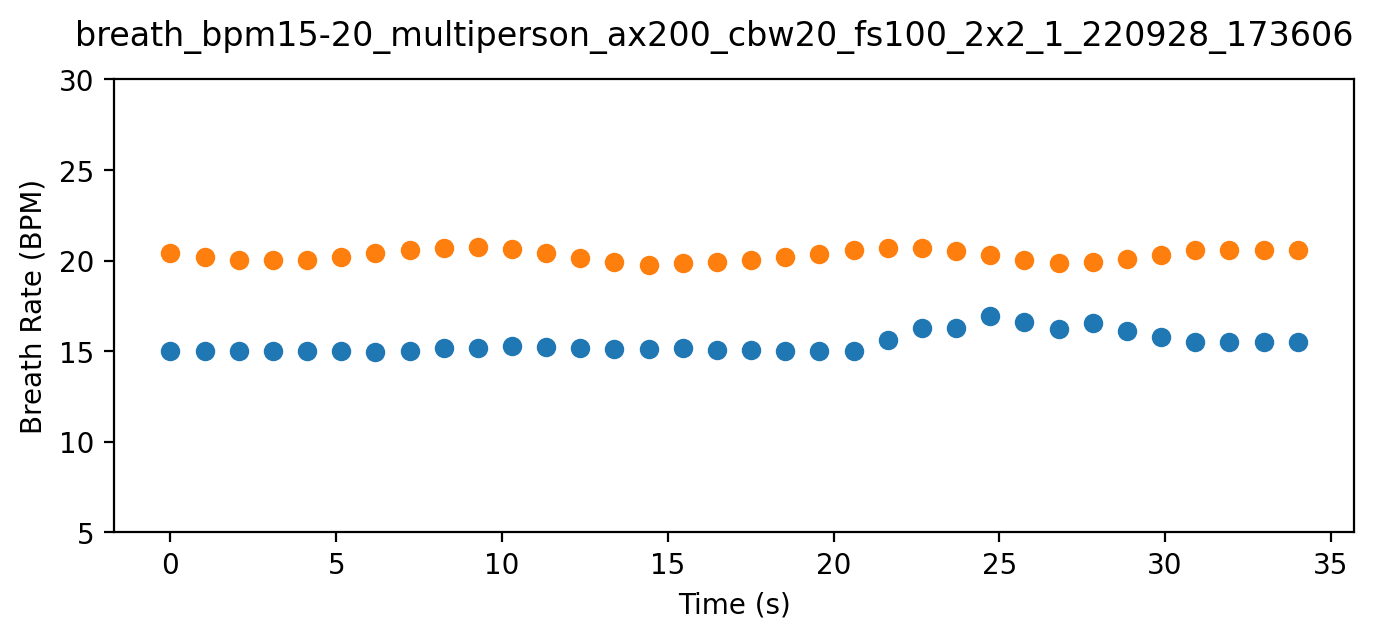

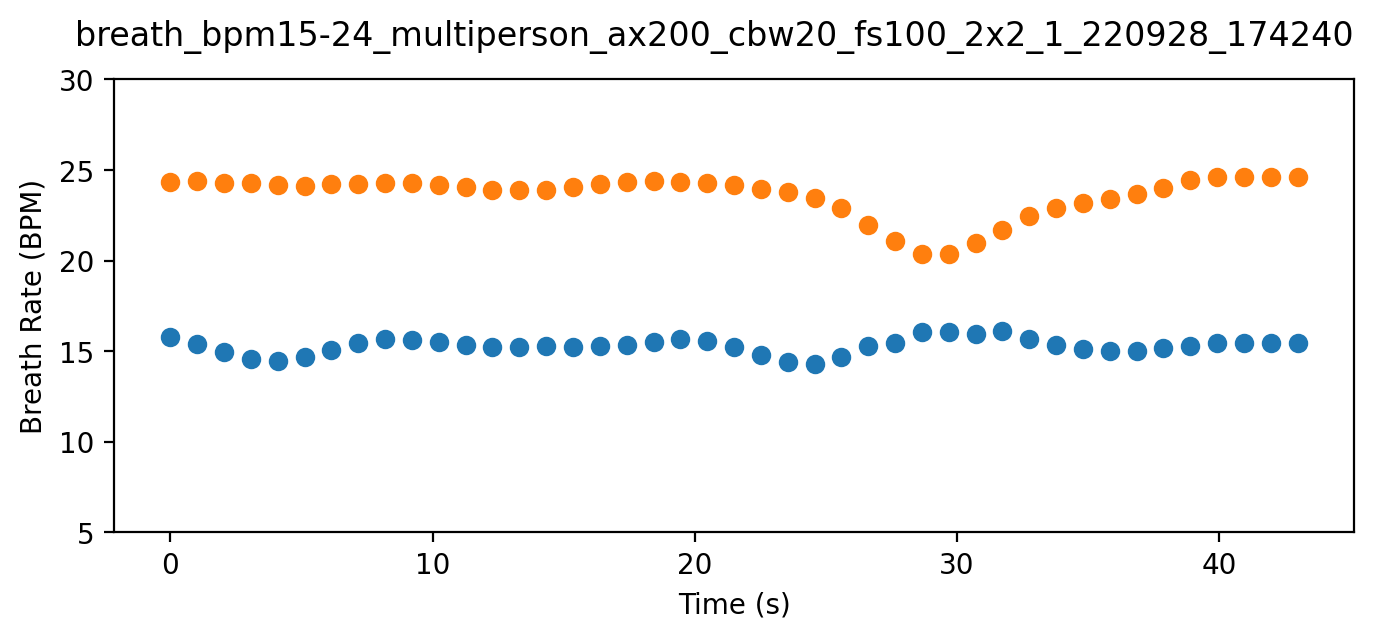

In [13]:
groundtruth = trainset['groundtruth']


def groundtruth_visualization(experiment_name, gt):
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 3), dpi=200)
    fig.suptitle(experiment_name)

    if isinstance(gt, list):
        # for the two-user mode, there are two groundtruth series in the groundtruth file
        time_axis = np.linspace(0, len(gt[0]), num=len(gt[0]))
        ax1.scatter(time_axis, gt[0], label="User#1")
        ax1.scatter(time_axis, gt[1], label="User#2")
    else:
        # for the one-user mode
        time_axis = np.linspace(0, len(gt), num=len(gt))
        ax1.scatter(
            time_axis,
            gt,
        )
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Breath Rate (BPM)')
    ax1.set_ylim(5, 30)
    plt.show()


for index, gt in enumerate(groundtruth):
    experiment_name = trainset['ex_name'][index][:-4]
    groundtruth_visualization(experiment_name, gt)

---
## Breath estimation pipeline

In this section, the breath estimation pipeline is presented by using the first experiment as an example. It is worth noting that this is just a showcase of the breath estimation method which is conducted on a simple task, namely, only one user in the office to perform breathing with a 12 BMP breath rate. For the varied breath rate estimation and two-user mode, you need to consider more than this.

### Data loading

For the sake of completeness, we copy the data loading code in the first section to this block.

In [14]:
with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

CSI = trainset['CSI']
CSI_amplitude = np.abs(
    CSI[0])  # the amplitude of CSI series of the first experiment
CSI_phase = np.angle(CSI[0])  # the phase of CSI series of the first experiment

groundtruth = trainset['groundtruth'][
    0]  # loading the ground-truth of the first experiment
experiment_name = trainset['ex_name'][0][:-4]
print("the name of the first experiment: ", experiment_name)

the name of the first experiment:  breath_bpm12_ax200_cbw20_fs100_2x2_1_220928_163813


<font color=red>**Note:**</font>

We only use one subcarrier's CSI amplitude from one link in this example.
Apparently, you need to consider all the links and subcarriers for addressing the other harder tasks like the two-user experiment and varied breath rate experiments. 

### Preprocessing

This step may contain denoise or data augmentation. Specifically, denoise is to eliminate the impact of random noise, and system noise (e.g., the outliers). If you want to use the phase of the CSI series to boost the performance of your breath detection model, you need to do the phase clean (a candidate method is that in the [WiDance](https://dl.acm.org/doi/abs/10.1145/3025453.3025678)). Data augmentation is a hot spot in the deep learning field, that is dedicated to strengthening the diversity, quantity, and quality of collected data. If you want to know about data augmentation methods in the WiFi sensing field, you can read the paper: [CsiGAN](https://ieeexplore.ieee.org/abstract/document/8808929). 

(6600,)


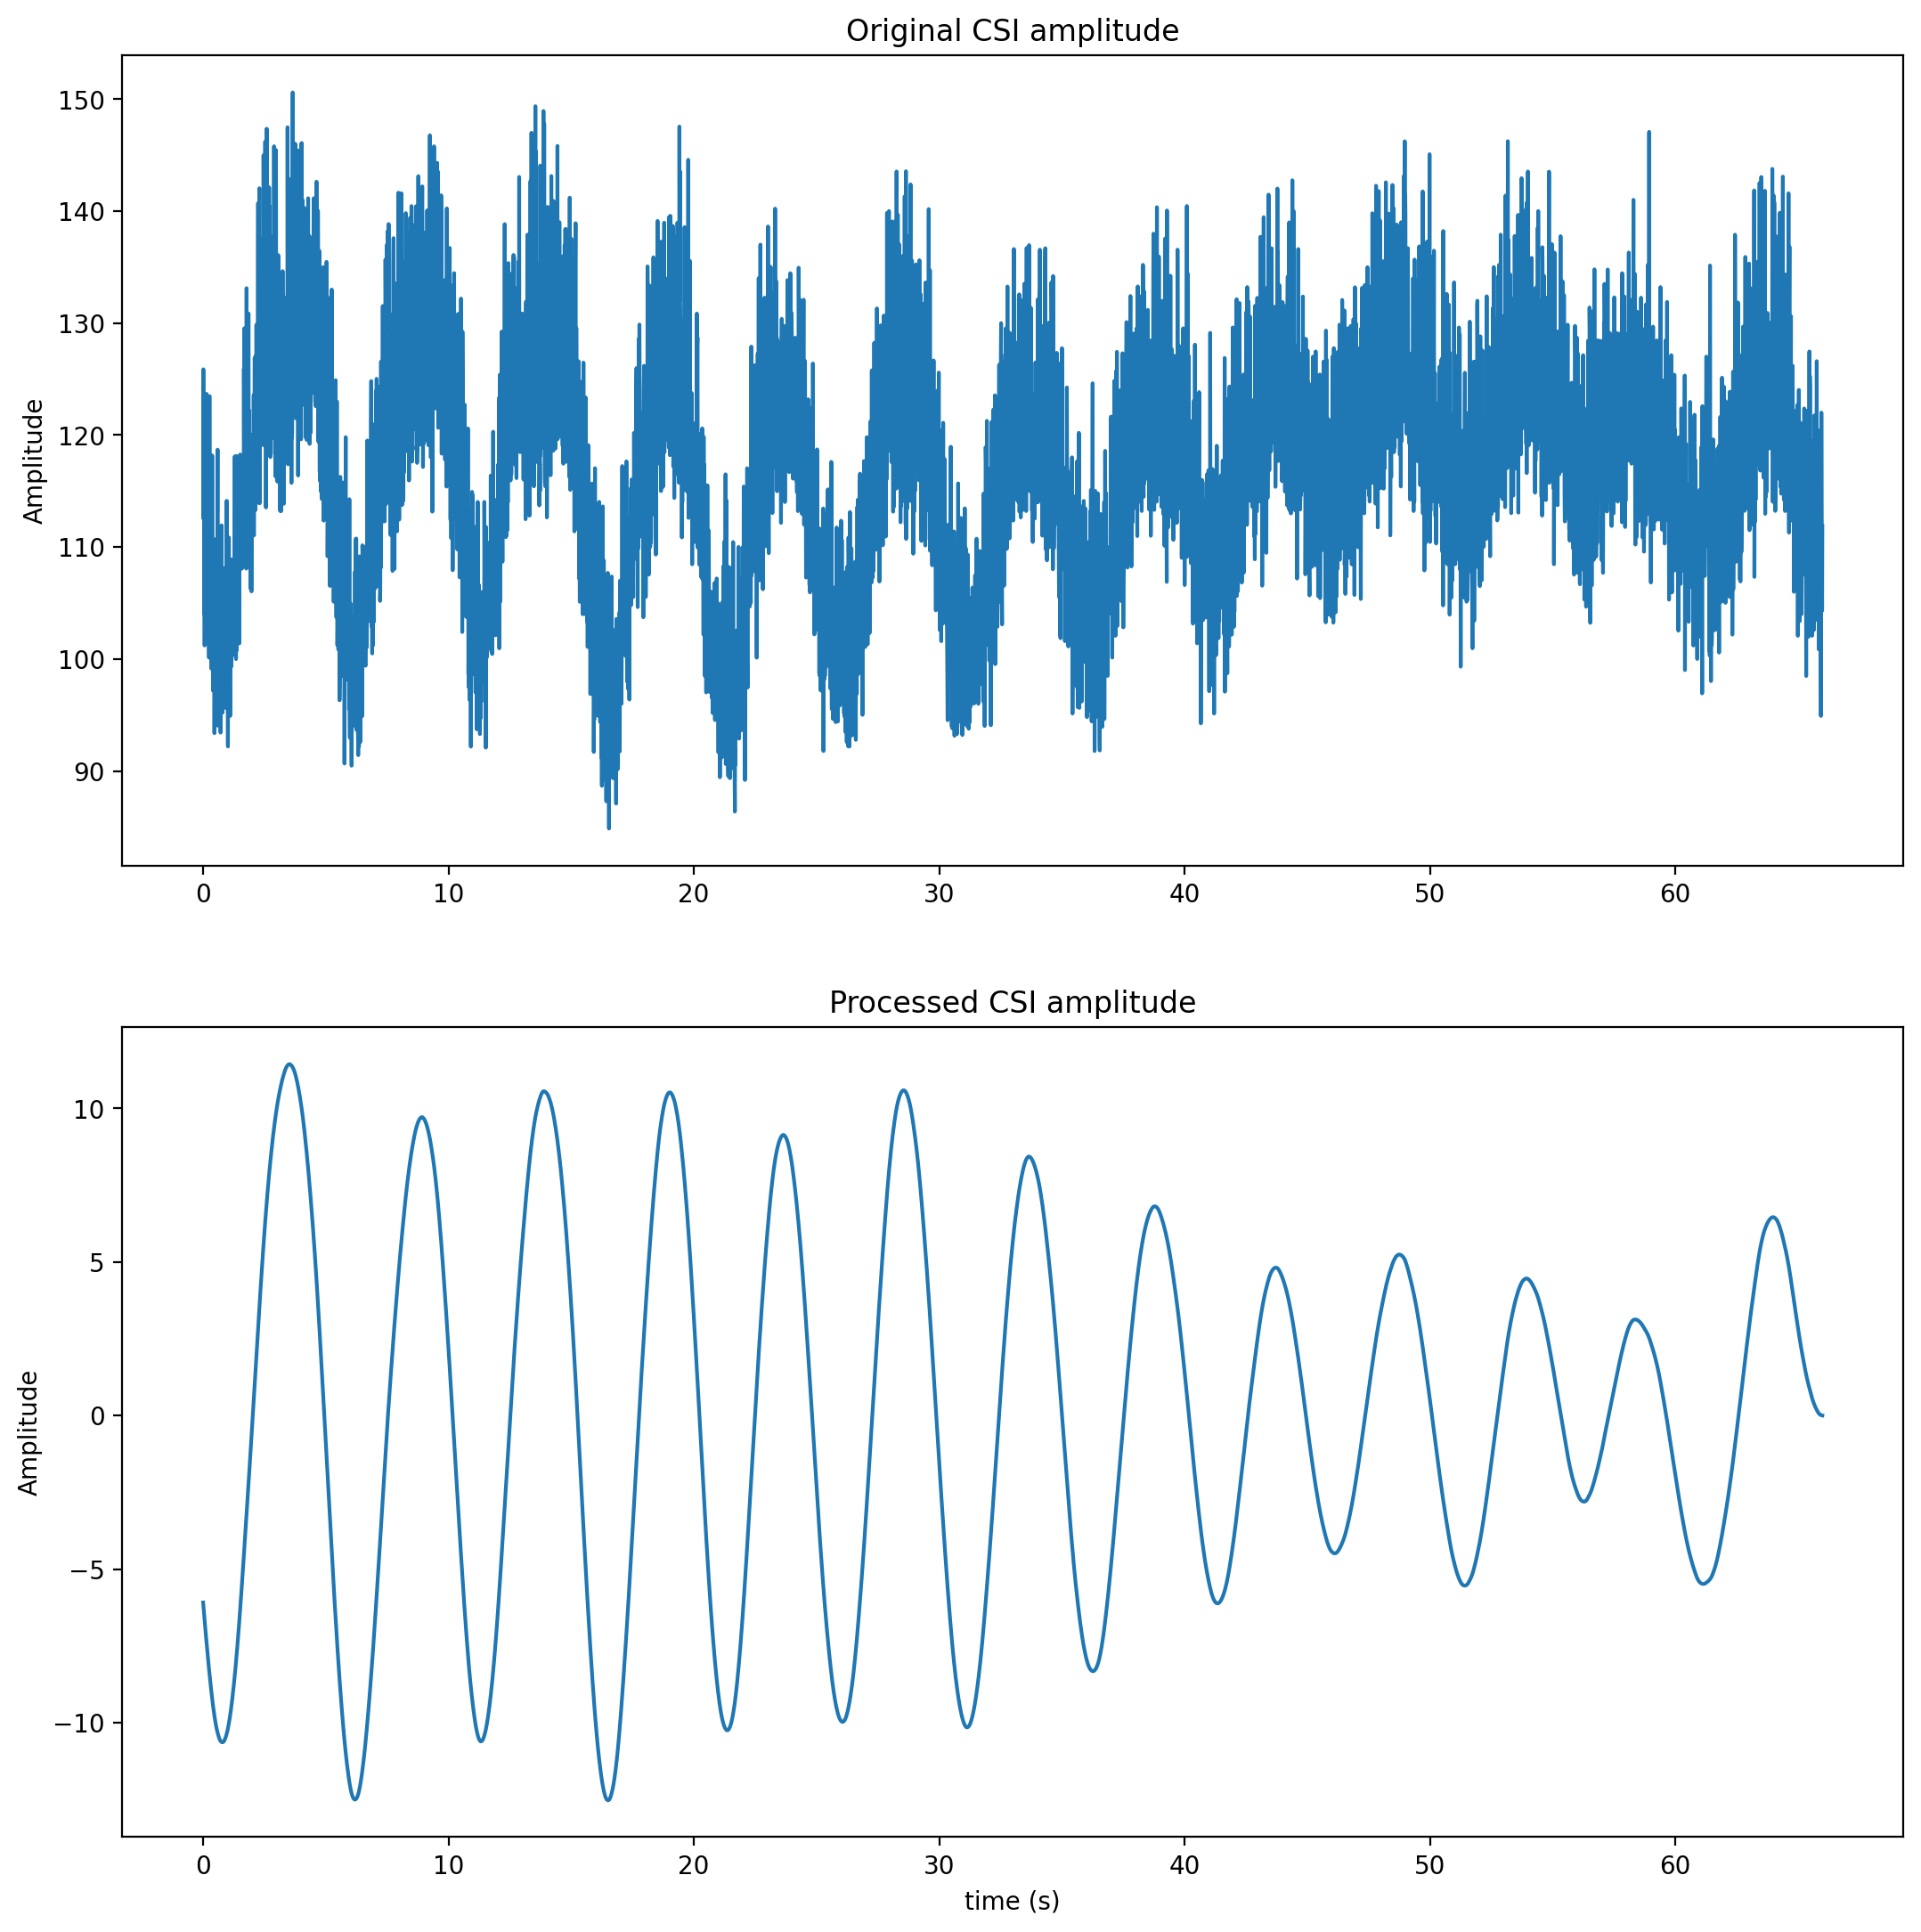

In [15]:
# Example: Using the Butterworth Bandpass Filter to preprocess the CSI amplitude
from scipy import signal

# Normly, the breath rate of an adult is bigger than 6 BPM (breath per minute), that is 0.1 Hz,
# and smaller than 30 bpm (0.5Hz).
# The CSI sampling frequency is 100 Hz
# Hence, the parameters in the Butterworth Bandpass Filter should be: 2*0.1/100 = 0.002 and 2*0.5/100=0.005
b, a = signal.butter(
    1,
    [0.002, 0.005],
    'bandpass',
)  # 1 is the order of the filter

# Since the data has been loaded, we skip the data loading part and directly select one subcarrier and one link.

selected_Rx = 0  # the selected of Rx: 0 or 1
selected_Tx = 1  # the selected of Tx: 0 or 1
selected_subcarrier = 15  # the selected subcarriers from 245 subcarriers
CSI_amp = CSI_amplitude[:, selected_subcarrier, selected_Rx, selected_Tx]

num_samples = CSI_amp.shape[0]  # the number of samples

filted_CSI_amp = signal.filtfilt(b, a, CSI_amp)

print(filted_CSI_amp.shape)

# visulization
time_axis = np.linspace(0, num_samples, num=num_samples)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), dpi=200)
plt.subplots_adjust(left=0.0, bottom=0.0, top=2, right=1)

ax1.plot(
    time_axis / 100,
    CSI_amp,
)
ax1.set_ylabel('Amplitude')
ax1.set_title('Original CSI amplitude')

ax2.plot(
    time_axis / 100,
    filted_CSI_amp,
)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Processed CSI amplitude')

plt.show()

<font color =blue>**Analysis:**</font>

We can see from the above figures that the preprocessing eliminates local rapid jittering of the amplitude while preserving the periodic pattern.

### Feature Extraction

The purpose of this part is to extract information (also called features) related to breathing. In this exsample, we use the FFT (Fast Fourier Transformation) to extract useful information for the breath detection. 

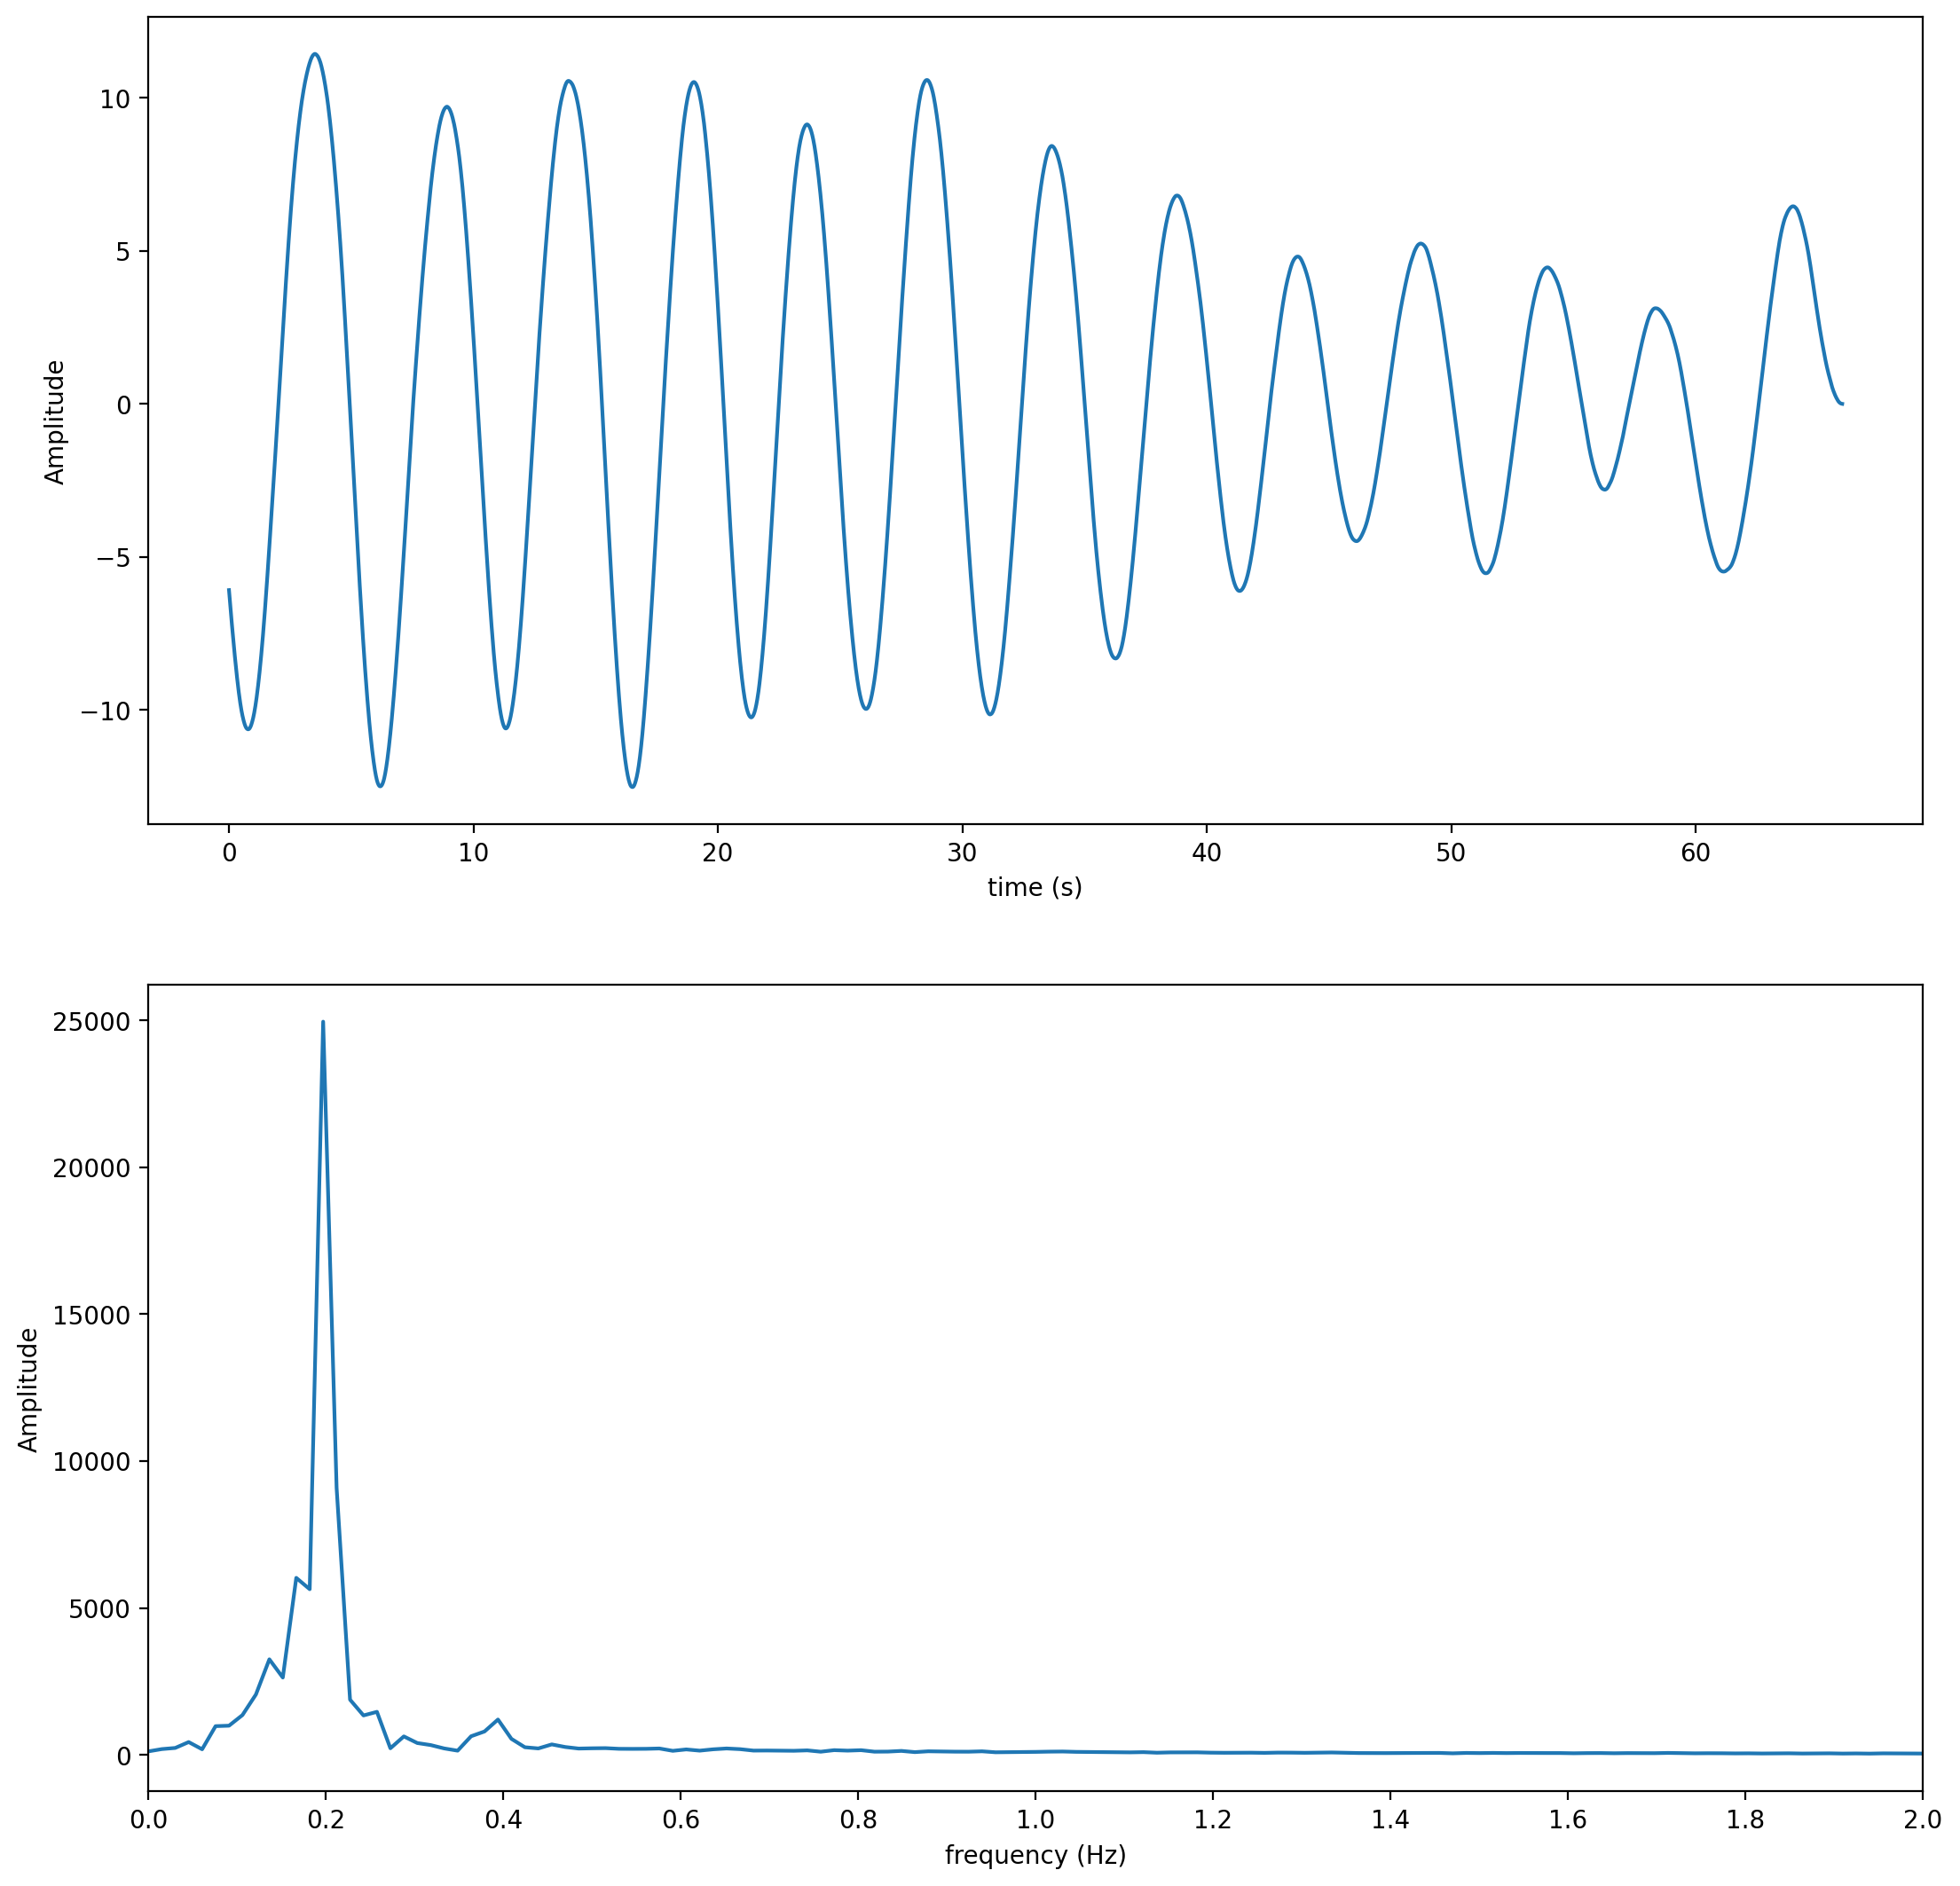

In [16]:
extracted_CSI = fft(filted_CSI_amp, )  # using the proprecessed sample as input

# visulization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), dpi=200)
plt.subplots_adjust(left=0.0, bottom=0.0, top=2, right=1)

time_axis = np.linspace(0,
                        filted_CSI_amp.shape[0],
                        num=filted_CSI_amp.shape[0])
ax1.plot(
    time_axis / 100,
    filted_CSI_amp,
)
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('time (s)')

N = extracted_CSI.shape[0]

ax2.plot(np.linspace(0, 50, N // 2), np.abs(extracted_CSI[:N // 2]))
ax2.set_xlabel('frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax2.set_xlim(0, 2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

plt.show()

<font color=red>**Note:**</font>

In this example, the breath rate's time variation is not taken into account.
Specifically, even thought the user controlled his breath rate at 12 BPM, there are tiny fluctuations during the experiment as shown in the figure of the ground-truth (refer to Section 2.3). To gain better estimation accuracy, the time variation should be considered in order to improve estimation accuracy, and STFT (Short Time Fourier Transformation) is required. 

There are some online sources about STFT:

- https://en.wikipedia.org/wiki/Short-time_Fourier_transform
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
- https://www.youtube.com/watch?v=-Yxj3yfvY-4


### Peak Detection

The location of the maximum of the "extracted CSI" is related to the predicted breathing rate based on the feature extraction approach described above.
Hence, to estimate the breathing rate, peak detection is needed.

Estimated breathing rate: 11.81818181818182 (BPM)


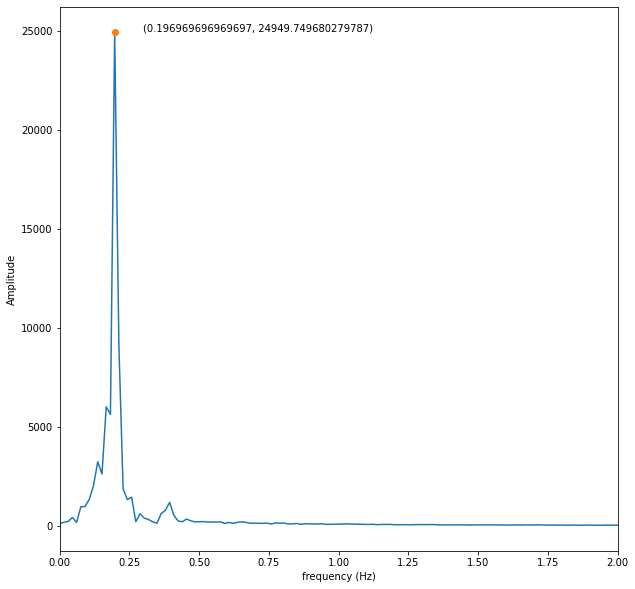

In [17]:
# Directely to get the location of maximum, a naive method.
max_value = np.max(np.abs(extracted_CSI))
arg_max = np.argmax(np.abs(extracted_CSI)) / (N // 2) * 50
result = arg_max * 60

N = extracted_CSI.shape[0]  # the number of points returned by the fft

# visualization
plt.figure(figsize=(10, 10))
plt.plot(np.linspace(0, 50, N // 2), np.abs(extracted_CSI[:N // 2]))
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude')
plt.plot(arg_max, max_value, 'o')
plt.xlim(0, 2)
plt.text(arg_max + 0.1, max_value,
         '(' + str(arg_max) + ', ' + str(max_value) + ')')
print("Estimated breathing rate:", result, "(BPM)")

<font color=red>**Note:**</font>
    
In the first experiment, there is only one user present in the office. 
We only need to estimate one breath rate series. In addition, We also assume that the breath rate is constant throughout the experiment because the breath rate's time variation is not taken into account.
Therefore, as demonstrated above, a single scalar can be used to describe the breath rate series: estimated breathing rate: 11.81818181818182 (BPM). 


### Result Evaluation

The mean square error (MSE) is used to evaluate the quality of the estimated breath rate. 
Additionally, the sampling rate of ground-truth series is 1 Hz,meaning that one measured breath rate is recorded every second.
To calculate the MSE, we need to up- or down-sampling the estimated breath rate series in order to provide one estimated breath rate per second.


MSE:  0.5307003360205628


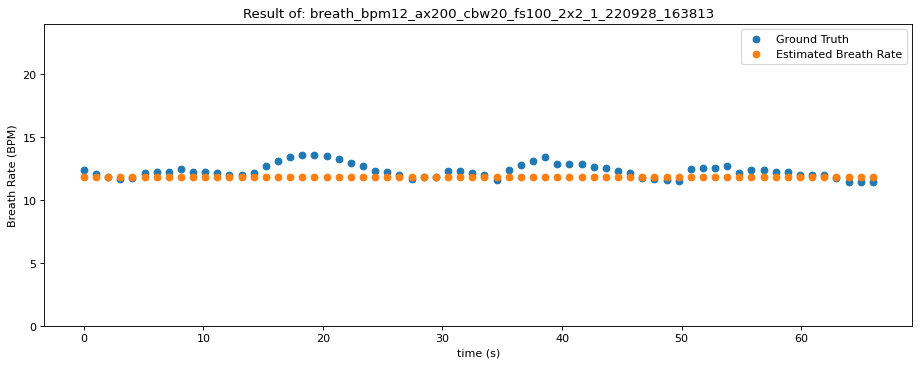

In [18]:
# In this example, we need to up-sampling the estimated breath rate series (one scalar is a special series).


def upsampling(result, l):
    """
    result: the series need to be up-sampled.
    l: the length of the return series.
    
    Note: in this example, we only need to repeat the estimated 
          breath rate scalar to construct the series with length l.
    """
    return [result for i in range(l)]


# up-sampling
final_result = upsampling(result, len(groundtruth))


def MSE(final_result, groundtruth):
    re = np.array(final_result)  # form list to numpy array
    gr = np.array(groundtruth)  # form list to numpy array
    return (np.sum((re - gr)**2)) / len(re)


mse = MSE(final_result, groundtruth)

print("MSE: ", mse)


# visulizing the estimated breath rate and ground-truth
def result_visulization(experiment_name, groundtruth, estimated_breath_rate):
    plt.figure(figsize=(14, 5), dpi=80)
    time_axis = np.linspace(0, len(groundtruth), num=len(groundtruth))
    plt.title('Result of: ' + experiment_name)

    plt.scatter(time_axis, groundtruth, label="Ground Truth")
    plt.scatter(time_axis,
                estimated_breath_rate,
                label="Estimated Breath Rate")
    plt.ylabel('Breath Rate (BPM)')
    plt.xlabel('time (s)')
    plt.ylim(0, 24)
    plt.legend()
    plt.show()


result_visulization(experiment_name, groundtruth, final_result)

---
---

# Part II: Task

Three tasks need to be completed in this part.
The level of difficulty gradually rises from task_1 to task_3. 

<font color=red>Note:</font>

The parts you need to complete will be marked with `# STEP`.

In [19]:
# importing some libraries we need in this part. You can add more as needed.
import scipy.io
import numpy as np
import os
from collections import defaultdict, Counter
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy import signal
from scipy.fft import fft, fftfreq

## Task1: Controlled breath estimation (one person) // Points: 60

In this task, you need to build a method for estimating a user's breathing rate in controlled mode. Specifically, <font color=red>there are two cases: 15 BPM and 20 BPM. You need to illustrate the building process of your method by using the 15 BPM case. While only the result evaluation is needed in the 20 BPM case. </font>
A basic version of this method has been demonstrated in the Part I.

### 15 BPM case // Points: 56

In [20]:
# Data for this task:
with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

CSI = trainset['CSI'][1]  # the CSI series
groundtruth = trainset['groundtruth'][1]  # loading the ground-truth
experiment_name = trainset['ex_name'][1][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm15_ax200_cbw20_fs100_2x2_1_220928_164837


In [86]:
# visualizing the CSI and ground-truth


def DataVisualization(CSI, groundtruth):
    pass  # Please remove this line before beginning your work below.

    # STEP #1: Visualize the CSI from 10s - 20s on subcarrier #17 of all links // Points: 7
    # 1.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 1.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # ==========================================================
    # STEP #2: Visualize the CSI from 10s - 40s on subcarrier #17 and #1 of the link (Tx1->Rx0) // Points: 7
    # 2.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 2.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #3: Visualize the ground-truth here (code) // Points: 7
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # Hint: 1. From the result of STEP #1, you can observe the differences of CSI among the different links.
    #       2. From the result of STEP #2, you can observe the differences of CSI among the different subcarriers.
    #       3. From the result of STEP #3, you can observe the breath rate's time variation.


DataVisualization(CSI, groundtruth)

In [ ]:
# Preprocessing

# Phase Cleaning
# the sanitization function is given to eliminate the phase offset
from cmath import pi


def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)


def phase_cleaning(CSI):
    for i in range(CSI.shape[0]):
        CSI[i, :, 0, 0] = sanitization(CSI[i, :, 0, 0])
        CSI[i, :, 0, 1] = sanitization(CSI[i, :, 0, 1])
        CSI[i, :, 1, 0] = sanitization(CSI[i, :, 1, 0])
        CSI[i, :, 1, 1] = sanitization(CSI[i, :, 1, 1])
    return CSI


def Preprocessing(CSI):
    CSI = phase_cleaning(CSI)  # cleaning phase first
    CSI_amplitude = np.abs(CSI)  # the amplitude of CSI series
    CSI_phase = np.angle(CSI)  # the phase of CSI series
    pass  # Please remove this line before beginning your work below.

    # STEP #4: Using a filter (e.g., Butterworth filter) to process the CSI amplitude and phase. // Points: 7
    #          The goal of this step is to eliminate the unexpected variations of CSI,
    #          while keep the overall variations related to breath.
    # 4.1: Process the CSI amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.2: Process the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3: Visualize both the oringal CSI and denoised CSI from 10s - 20s on subcarrier #12 of the link (Tx1->Rx0)
    # 4.3.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the denoised CSI as follows:
    # Return processed_CSI_amplitude, processed_CSI_phase


processed_CSI_amplitude, processed_CSI_phase = Preprocessing(CSI)

In [ ]:
# Feature Detection
# In this task, you can use either CSI amplitude or CSI phase to estimate the breath rate.
# You need to determine which one to use, amplitude or phase, by yourself.
def FeatureDetection(processed_CSI_amplitude, processed_CSI_phase):
    # STEP #5: There are three decisions to make:  // Points: 7
    #          1. Which link you will use?
    #             You can choose the link with the most significant periodic pattern (based on the SETP #1 visulization)
    #             or the link which gives the lowest MSE at the end as the right one.
    #          2. Which subcarrier you will use?
    #             You can choose the subcarrier with the most significant periodic pattern (by using the visulization method in STEP #2)
    #             or the subcarrier which gives the lowest MSE at the end as the right one.
    #          3. Which one will you use? Amplitude or phase.
    #             You can make the decision by slecting the one has the most significant periodic pattern (based on the SETP #4 visulization)
    #             or the subcarrier which gives the lowest MSE at the end as the right one.
    #
    # 5.1: your decision (please change the default value to your setting):
    selected_Rx = 0  # the selected of Rx: 0 or 1
    selected_Tx = 1  # the selected of Tx: 0 or 1
    selected_subcarrier = 15  # the selected subcarriers from 245 subcarriers
    selected_component = processed_CSI_amplitude[:, selected_subcarrier,
                                                 selected_Rx, selected_Tx]
    # OR: selected_component = processed_CSI_phase[:,selected_subcarrier,selected_Rx,selected_Tx]
    #
    # 5.2: Visualize the selected_component here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #6: Using FFT (Faset Fourier Transformation) to extract the breath-related features // Points: 9
    #          from the selected_component.
    #          e.g., feature = fft(selected_component, )
    #               !!!! There are parameters in the scipy fft function, please check the
    #                    doc: https://docs.scipy.org/doc/scipy/tutorial/fft.html.
    # 6.1: Processing the selected_component here (code)
    # feature = ???
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 6.2: Visulize the feature here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return as follows:
    # Return feature
    pass  # Please remove this line before beginning your work.


feature = FeatureDetection(processed_CSI_amplitude, processed_CSI_phase)

In [25]:
# breath detection
# The location of the maximum of the "feature" is related to the predicted breathing rate
# based on the feature extraction approach described above.
# Hence, to estimate the breathing rate, we only need to find the peak location of 'feature'.


def BreathDetection(feature):
    pass  # Please remove this line before beginning your work below.

    # STEP #7:  // Points: 9
    # 7.1: Find the location of peak in feature (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.2: Transform the location of peak to estimated breath rate (unit: BPM) here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.3: Visulize the location of peak with the feature as that in the Secion 3.4, Part I (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the estimated breath rate 'result' as follows:
    # Return result


result = BreathDetection(feature)

In [ ]:
# Now, you need to up-sampling the estimated breath rate series.
def upsampling(result, l):
    """
    result: the series need to be up-sampled.
    l: the length of the return series.
    
    Note: in this example, we only need to repeat the estimated 
          breath rate scalar to construct the series with length l.
    """
    return [result for i in range(l)]


# up-sampling
final_result = upsampling(result, len(groundtruth))


def MSE(final_result, groundtruth):
    re = np.array(final_result)  # form list to numpy array
    gr = np.array(groundtruth)  # form list to numpy array
    return (np.sum((re - gr)**2)) / len(re)


mse = MSE(final_result, groundtruth)

print("MSE: ", mse)


def result_visulization(groundtruth, final_result):
    pass  # Please remove this line before beginning your work below.
    # STEP #8: visulizing the estimated breath rate and ground-truth // Points: 3


result_visulization(groundtruth, final_result)

### 20 BPM case // Points: 4

In this part, you don't need to write code. You just need to run this part of the code to test the performance of the method you built in the above part in the 20 BPM case.

In [21]:
CSI = trainset['CSI'][2]  # the CSI series
groundtruth = trainset['groundtruth'][2]  # loading the ground-truth
experiment_name = trainset['ex_name'][2][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm20_ax200_cbw20_fs100_2x2_1_220928_165545


In [ ]:
processed_CSI_amplitude, processed_CSI_phase = Preprocessing(CSI)
feature = FeatureDetection(processed_CSI_amplitude, processed_CSI_phase)
result = BreathDetection(feature)
final_result = upsampling(result, len(groundtruth))
mse = MSE(final_result, groundtruth)
result_visulization(groundtruth, final_result)
print("MSE: ", mse)

---
## Task2: Controlled breath estimation (two person)  // Points: 10

In this task, you need to build a method for estimating two users' breathing rates in controlled mode. Specifically, <font color=red>there are two cases: Case1: one user with 15 BMP and another with 20 BMP; case2: one user with 15 BMP and another with 24 BMP. The method for this task is similar to the Task1. While the result should be two estimated breath rates. You need to illustrate the building process of your method by using the 15-20 BPM case. While only the result evaluation is needed in the 15-24 BPM case. </font>

### 15-20 BPM case // Points: 8

In [22]:
# Data for this task:
with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

CSI = trainset['CSI'][6]  # the CSI series
groundtruth = trainset['groundtruth'][6]  # loading the ground-truth
experiment_name = trainset['ex_name'][6][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm15-20_multiperson_ax200_cbw20_fs100_2x2_1_220928_173606


In [ ]:
# visualizing the CSI and ground-truth
# The CSI visulization part is the same with that in Task1.
# !!!!! But, there are two ground-truth series visulizing in one fgiure.


def DataVisualization(CSI, groundtruth):
    pass  # Please remove this line before beginning your work below.

    # STEP #1: Visualize the CSI from 10s - 20s on subcarrier #17 of all links
    # 1.1: Visualize the amplitude here (code) // same with that of Task1
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 1.2: Visualize the phase here (code) // same with that of Task1
    # YOUR CODE HERE

    # END OF YOUR CODE

    # ==========================================================
    # STEP #2: Visualize the CSI from 10s - 40s on subcarrier #17 and #1 of the link (Tx1->Rx0)
    # 2.1: Visualize the amplitude here (code) // same with that of Task1
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 2.2: Visualize the phase here (code) // same with that of Task1
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #3: Visualize the ground-truth here (code) // different with that of Task1  // Points: 1
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # Hint: 1. From the result of STEP #1, you can observe the differences of CSI among the different links.
    #       2. From the result of STEP #2, you can observe the differences of CSI among the different subcarriers.
    #       3. From the result of STEP #3, you can observe the breath rate's time variation.


DataVisualization(CSI, groundtruth)

In [ ]:
# Preprocessing
# You can use the same code from Task1. It would be better if you modified some of it to adapt to this task.

# Phase Cleaning
# the sanitization function is given to eliminate the phase offset
from cmath import pi


def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)


def phase_cleaning(CSI):
    for i in range(CSI.shape[0]):
        CSI[i, :, 0, 0] = sanitization(CSI[i, :, 0, 0])
        CSI[i, :, 0, 1] = sanitization(CSI[i, :, 0, 1])
        CSI[i, :, 1, 0] = sanitization(CSI[i, :, 1, 0])
        CSI[i, :, 1, 1] = sanitization(CSI[i, :, 1, 1])
    return CSI


def Preprocessing(CSI):
    CSI = phase_cleaning(CSI)  # cleaning phase
    CSI_amplitude = np.abs(CSI)  # the amplitude of CSI series
    CSI_phase = np.angle(CSI)  # the phase of CSI series
    pass  # Please remove this line before beginning your work below.

    # STEP #4: Using a filter (e.g., Butterworth filter) to process the CSI amplitude and phase. // Points: 2
    #          The goal of this step is to eliminate the unexpected variations of CSI,
    #          while keep the overall variations related to breath.
    # 4.1: Process the CSI amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.2: Process the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3: Visualize both the oringal CSI and denoised CSI from 10s - 20s on subcarrier #12 of the link (Tx1->Rx0)
    # 4.3.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the denoised CSI as follows:
    # Return processed_CSI_amplitude, processed_CSI_phase


processed_CSI_amplitude, processed_CSI_phase = Preprocessing(CSI)

In [ ]:
# Feature Detection
# You can use the same code from Task1. It would be better if you modified some of it to adapt to this task.


def FeatureDetection(processed_CSI_amplitude, processed_CSI_phase):
    # STEP #5: There are three decisions to make:   // Points: 1
    #          1. Which link you will use?
    #             You can choose the link with the most significant periodic pattern (based on the SETP #1 visulization)
    #             or the link which gives the lowest MSE at the end as the right one.
    #          2. Which subcarrier you will use?
    #             You can choose the subcarrier with the most significant periodic pattern (by using the visulization method in STEP #2)
    #             or the subcarrier which gives the lowest MSE at the end as the right one.
    #          3. Which one will you use? Amplitude or phase.
    #             You can make the decision by slecting the one has the most significant periodic pattern (based on the SETP #4 visulization)
    #             or the subcarrier which gives the lowest MSE at the end as the right one.
    #
    # 5.1: your decision (please change the default value to your setting):
    selected_Rx = 0  # the selected of Rx: 0 or 1
    selected_Tx = 1  # the selected of Tx: 0 or 1
    selected_subcarrier = 15  # the selected subcarriers from 245 subcarriers
    selected_component = processed_CSI_amplitude[:, selected_subcarrier,
                                                 selected_Rx, selected_Tx]
    # OR: selected_component = processed_CSI_phase[:,selected_subcarrier,selected_Rx,selected_Tx]
    #
    # 5.2: Visualize the selected_component here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #6: Using FFT (Faset Fourier Transformation) to extract the breath-related features  // Points: 1
    #          from the selected_component.
    #          e.g., feature = fft(selected_component, )
    #               !!!! There are parameters in the scipy fft function, please check the
    #                    doc: https://docs.scipy.org/doc/scipy/tutorial/fft.html.
    # 6.1: Processing the selected_component here (code)
    # feature = ???
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 6.2: Visulize the feature here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return as follows:
    # Return feature
    pass  # Please remove this line before beginning your work.


feature = FeatureDetection(processed_CSI_amplitude, processed_CSI_phase)

In [ ]:
# breath detection: this block is different with that in the Task1
#                   given that there are two users with different breath rates in this task.
# The locations of the largest two values of the "feature" related to the breathing rates of the two users.
# Hence, to estimate the breathing rates, we need to find the first and second peaks' location of 'feature'.


def BreathDetection(feature):
    pass  # Please remove this line before beginning your work below.

    # STEP #7:   // Points: 2
    # 7.1: Find the location of the first peak in feature (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.2: Find the location of the second peak in feature (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.3: Transform the locations of peaks to estimated breath rates (unit: BPM) here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.4: Visulize the locations of peaks with the feature as that in the Secion 3.4, Part I (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the estimated breath rates as follows:
    # Return result_user1, result_user2


result_user1, result_user2 = BreathDetection(feature)

In [ ]:
# Now, you need to up-sampling the estimated breath rate series.
def upsampling(result, l):
    """
    result: the series need to be up-sampled.
    l: the length of the return series.
    
    Note: in this example, we only need to repeat the estimated 
          breath rate scalar to construct the series with length l.
    """
    return [result for i in range(l)]


# up-sampling
final_result_user1 = upsampling(result_user1, len(groundtruth[0]))
final_result_user2 = upsampling(result_user2, len(groundtruth[1]))


def MSE(final_result, groundtruth):
    re = np.array(final_result)  # form list to numpy array
    gr = np.array(groundtruth)  # form list to numpy array
    return (np.sum((re - gr)**2)) / len(re)


mse_user1 = MSE(final_result_user1, groundtruth[0])
mse_user2 = MSE(final_result_user2, groundtruth[1])

print("MSE-user1: ", mse_user1)
print("MSE-user2: ", mse_user2)


def result_visulization(groundtruth, final_result):
    pass  # Please remove this line before beginning your work below.
    # STEP #8: visulizing the estimated breath rate and ground-truth // Points: 1
    # YOUR CODE HERE

    # END OF YOUR CODE


result_visulization(groundtruth[0], final_result_user1)
result_visulization(groundtruth[2], final_result_user2)

### 15-24 BPM case // Points: 2

In this part, you don't need to write code. You just need to run this part of the code to test the performance of the method you built in the above part in the 15-24 BPM case.

In [23]:
CSI = trainset['CSI'][7]  # the CSI series
groundtruth = trainset['groundtruth'][7]  # loading the ground-truth
experiment_name = trainset['ex_name'][7][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm15-24_multiperson_ax200_cbw20_fs100_2x2_1_220928_174240


In [ ]:
processed_CSI_amplitude, processed_CSI_phase = Preprocessing(CSI)
feature = FeatureDetection(processed_CSI_amplitude, processed_CSI_phase)
result_user1, result_user2 = BreathDetection(feature)
final_result_user1 = upsampling(result_user1, len(groundtruth[0]))
final_result_user2 = upsampling(result_user2, len(groundtruth[1]))
mse_user1 = MSE(final_result_user1, groundtruth[0])
mse_user2 = MSE(final_result_user2, groundtruth[1])
print("MSE-user1: ", mse_user1)
print("MSE-user2: ", mse_user2)
result_visulization(groundtruth[0], final_result_user1)
result_visulization(groundtruth[2], final_result_user2)

---
## Task3: Varied breath estimation (one person) // Points: 10

In this task, you need to build a method for estimating one user's breathing rate in varied mode. Specifically, <font color=red>there are two cases: </font>
    
- Case1: The experiment of one person with varied breath rates decreased from 24 BMP to 12 BMP (breath per minute).
- Case2: The experiment of one person with varied breath rates increased from 12 BMP to 24 BMP (breath per minute).

The method for this task is similar to the Task1 to some extent. However, since the breath rates are varied throughout the experiment, we need to utilize STFT (not FFT) to extract the features at different time.

You need to illustrate the building process of your method in the Case1. While only the result evaluation is needed in the Case2.

### Case1: // Points: 8

In [92]:
# Data for this task:
with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

CSI = trainset['CSI'][3]  # the CSI series
groundtruth = trainset['groundtruth'][3]  # loading the ground-truth
experiment_name = trainset['ex_name'][3][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm24-12_ax200_cbw20_fs100_2x2_1_220928_172548


In [ ]:
# visualizing the CSI and ground-truth: reuse the code form Task1.


def DataVisualization(CSI, groundtruth):
    pass  # Please remove this line before beginning your work below.

    # STEP #1: Visualize the CSI from 10s - 20s on subcarrier #17 of all links
    # 1.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 1.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # ==========================================================
    # STEP #2: Visualize the CSI from 10s - 40s on subcarrier #17 and #1 of the link (Tx1->Rx0)
    # 2.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 2.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #3: Visualize the ground-truth here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # Hint: 1. From the result of STEP #1, you can observe the differences of CSI among the different links.
    #       2. From the result of STEP #2, you can observe the differences of CSI among the different subcarriers.
    #       3. From the result of STEP #3, you can observe the breath rate's time variation.


DataVisualization(CSI, groundtruth)

In [ ]:
# Preprocessing
# You can use the same code from Task1. It would be better if you modified some of it to adapt to this task.

# Phase Cleaning
# the sanitization function is given to eliminate the phase offset
from cmath import pi


def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)


def phase_cleaning(CSI):
    for i in range(CSI.shape[0]):
        CSI[i, :, 0, 0] = sanitization(CSI[i, :, 0, 0])
        CSI[i, :, 0, 1] = sanitization(CSI[i, :, 0, 1])
        CSI[i, :, 1, 0] = sanitization(CSI[i, :, 1, 0])
        CSI[i, :, 1, 1] = sanitization(CSI[i, :, 1, 1])
    return CSI


def Preprocessing(CSI):
    CSI = phase_cleaning(CSI)  # cleaning phase
    CSI_amplitude = np.abs(CSI)  # the amplitude of CSI series
    CSI_phase = np.angle(CSI)  # the phase of CSI series
    pass  # Please remove this line before beginning your work below.

    # STEP #4: Using a filter (e.g., Butterworth filter) to process the CSI amplitude and phase.  // Points: 1
    #          The goal of this step is to eliminate the unexpected variations of CSI,
    #          while keep the overall variations related to breath.
    # 4.1: Process the CSI amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.2: Process the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3: Visualize both the oringal CSI and denoised CSI from 10s - 20s on subcarrier #12 of the link (Tx1->Rx0)
    # 4.3.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the denoised CSI as follows:
    # Return processed_CSI_amplitude, processed_CSI_phase


processed_CSI_amplitude, processed_CSI_phase = Preprocessing(CSI)

In [ ]:
# Feature Detection
# The part is different with the those in Task1 and Task2 given that the breath rate is varied.
# You need to use STFT to do the feature extraction.

# There are some online sources about STFT:
# - https://en.wikipedia.org/wiki/Short-time_Fourier_transform
# - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
# - https://www.youtube.com/watch?v=-Yxj3yfvY-4


def FeatureDetection(processed_CSI_amplitude, processed_CSI_phase):
    # STEP #5: There are three decisions to make:
    #          1. Which link you will use?
    #             You can choose the link with the most significant periodic pattern (based on the SETP #1 visulization)
    #             or the link which gives the lowest MSE at the end as the right one.
    #          2. Which subcarrier you will use?
    #             You can choose the subcarrier with the most significant periodic pattern (by using the visulization method in STEP #2)
    #             or the subcarrier which gives the lowest MSE at the end as the right one.
    #          3. Which one will you use? Amplitude or phase.
    #             You can make the decision by slecting the one has the most significant periodic pattern (based on the SETP #4 visulization)
    #             or the subcarrier which gives the lowest MSE at the end as the right one.
    #
    # 5.1: your decision (please change the default value to your setting):
    selected_Rx = 0  # the selected of Rx: 0 or 1
    selected_Tx = 1  # the selected of Tx: 0 or 1
    selected_subcarrier = 15  # the selected subcarriers from 245 subcarriers
    selected_component = processed_CSI_amplitude[:, selected_subcarrier,
                                                 selected_Rx, selected_Tx]
    # OR: selected_component = processed_CSI_phase[:,selected_subcarrier,selected_Rx,selected_Tx]
    #
    # 5.2: Visualize the selected_component here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #6: Using STFT to extract the breath-related features     // Points: 2
    # 6.1: Processing the selected_component here (code)
    # feature = ???
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 6.2: Visulize the feature here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return as follows:
    # Return feature
    pass  # Please remove this line before beginning your work.


feature = FeatureDetection(processed_CSI_amplitude, processed_CSI_phase)

In [ ]:
# breath detection: this block is different with those in the Task1 and Task2
#                   given that we use STFT for feature extraction in this task.
# The feature in this task is a 2-D map where the x-axis is time windows and the y-axis is frequency.
# You need to find the peak in different time windows. And the location of this peak is related to the
# user's breath rate in that time window. Hence, the below BreathDetection will return a series of the
# estimated breath rates.


def BreathDetection(feature):
    pass  # Please remove this line before beginning your work below.

    # STEP #7: // Points: 3
    # 7.1: Find the the peaks of all time window in feature (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.2: Transform the locations of peaks to estimated breath rates (unit: BPM) here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.3: Visulize the locations of peaks in the feature (2D-matrix version). (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the estimated breath rates as follows:
    # Return result


result = BreathDetection(feature)

In [ ]:
# Now, you need to up-sampling or down-sampling the estimated breath rate series.
# This part is different with those in Task1 and Task2.
# Specifically, in Task1 and Task2, the breath rate is controlled
# that means we can use one scalar to represent the breath rate of one user throughout the experiment.
# However, in this task, by using the STFT, the 'result' is a series of estimated breath rate.
# You may need to either up-sample or down-sample it, that depends on the time window size you use in STFT.

# there are some online resources about the resample:
# - https://www.geeksforgeeks.org/how-to-resample-time-series-data-in-python/
# - https://machinelearningmastery.com/resample-interpolate-time-series-data-python/
# - https://www.kaggle.com/code/bhavinmoriya/upsampling-and-downsampling-of-time-series


def up_down_sampling(result, l):
    """
    result: the series need to be up-sampled or down-sampled.
    l: the length of the return series.
    """
    pass  # Please remove this line before beginning your work below.

    # STEP #8: up-sampling or down-sampling your result here (code)  // Points: 2
    # YOUR CODE HERE

    # END OF YOUR CODE

    # Return final_result


final_result = up_down_sampling(result, len(groundtruth))


def MSE(final_result, groundtruth):
    re = np.array(final_result)  # form list to numpy array
    gr = np.array(groundtruth)  # form list to numpy array
    return (np.sum((re - gr)**2)) / len(re)


mse = MSE(final_result, groundtruth)

print("MSE: ", mse)


def result_visulization(groundtruth, final_result):
    pass  # Please remove this line before beginning your work below.
    # STEP #9: visulizing the estimated breath rate and ground-truth
    # YOUR CODE HERE

    # END OF YOUR CODE


result_visulization(groundtruth, final_result)

### Case2: // Points: 2

In this part, you don't need to write code. You just need to run this part of the code to test the performance of the method you built in the above part in the Case2.

In [24]:
# Data for this task:
with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

CSI = trainset['CSI'][4]  # the CSI series
groundtruth = trainset['groundtruth'][4]  # loading the ground-truth
experiment_name = trainset['ex_name'][4][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm12-24_ax200_cbw20_fs100_2x2_1_220928_171013


In [ ]:
processed_CSI_amplitude, processed_CSI_phase = Preprocessing(CSI)
feature = FeatureDetection(processed_CSI_amplitude, processed_CSI_phase)
result = BreathDetection(feature)
final_result = up_down_sampling(result, len(groundtruth))
mse = MSE(final_result, groundtruth)
print("MSE: ", mse)
result_visulization(groundtruth, final_result)

---
## Advanced Task (Optional Bonus)

In this part, you need to build a method for estimating one user's breathing rate in varied mode. Specifically, <font color=red>The experiment of one person with varied breath rates increased from 12 BMP to 24 BMP, and then back to 12 BMP. </font>
New Things:
- we need to aggregate different subcarriers and links.
- The STFT will directly be used on the complexed CSI.

In [25]:
# Data for this part:
with open('trainset.pickle', 'rb') as handle:
    trainset = pickle.load(handle)

CSI = trainset['CSI'][5]  # the CSI series
groundtruth = trainset['groundtruth'][5]  # loading the ground-truth
experiment_name = trainset['ex_name'][5][:-4]
print("the name of this experiment: ", experiment_name)

the name of this experiment:  breath_bpm12-24-12_ax200_cbw20_fs100_2x2_1_220928_170213


In [ ]:
# visualizing the CSI and ground-truth: reuse the code form Task1.


def DataVisualization(CSI, groundtruth):
    pass  # Please remove this line before beginning your work below.

    # STEP #1: Visualize the CSI from 10s - 20s on subcarrier #17 of all links
    # 1.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 1.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # ==========================================================
    # STEP #2: Visualize the CSI from 10s - 40s on subcarrier #17 and #1 of the link (Tx1->Rx0)
    # 2.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 2.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # STEP #3: Visualize the ground-truth here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # =========================================================
    # Hint: 1. From the result of STEP #1, you can observe the differences of CSI among the different links.
    #       2. From the result of STEP #2, you can observe the differences of CSI among the different subcarriers.
    #       3. From the result of STEP #3, you can observe the breath rate's time variation.


DataVisualization(CSI, groundtruth)

In [ ]:
# Preprocessing

# Phase Cleaning
# the sanitization function is given to eliminate the phase offset
from cmath import pi


def sanitization(x):
    F = len(x)
    phase = np.angle(x)
    phase = np.unwrap(phase)
    a = (phase[-1] - phase[0]) / (2 * pi * F)
    b = sum(phase) / F

    firstpart = (np.arange(F) + 1) * a
    secondpart = np.ones(F) * b
    phase = phase - firstpart - secondpart

    return x * np.exp(1j * phase)


def phase_cleaning(CSI):
    for i in range(CSI.shape[0]):
        CSI[i, :, 0, 0] = sanitization(CSI[i, :, 0, 0])
        CSI[i, :, 0, 1] = sanitization(CSI[i, :, 0, 1])
        CSI[i, :, 1, 0] = sanitization(CSI[i, :, 1, 0])
        CSI[i, :, 1, 1] = sanitization(CSI[i, :, 1, 1])
    return CSI


def Preprocessing(CSI):
    CSI = phase_cleaning(CSI)  # phase cleaning
    CSI_amplitude = np.abs(CSI)  # the amplitude of CSI series
    CSI_phase = np.angle(CSI)  # the phase of CSI series
    pass  # Please remove this line before beginning your work below.

    # STEP #4: Using a filter (e.g., Butterworth filter) to process the CSI amplitude and phase.
    #          The goal of this step is to eliminate the unexpected variations of CSI,
    #          while keep the overall variations related to breath.
    # 4.1: Process the CSI amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.2: Process the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3: Visualize both the oringal CSI and denoised CSI from 10s - 20s on subcarrier #12 of the link (Tx1->Rx0)
    # 4.3.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 4.3.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: we need to return the complex CSI
    # Return processed_CSI_amplitude * exp(-j*processed_CSI_phase)


processed_CSI = Preprocessing(CSI)

In [ ]:
# Feature Detection
# In this part, you need to use PCA (Principal Component Analysis to aggregate subcarriers and links)
# OR: you can use other method to fuse them.


def Aggregation(CSI):
    pass  # Please remove this line before beginning your work below.
    # STEP #5:
    # 5.1 links and subcarriers aggregation here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 5.2: Visualize the aggregated CSI
    # 5.2.1: Visualize the amplitude here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 5.2.2: Visualize the phase here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # return aggregated_CSI


aggregated_CSI = Aggregation(processed_CSI)


def FeatureDetection(aggregated_CSI):
    # STEP #6: Using STFT to extract the breath-related features
    # 6.1: Processing the selected_component here (code)
    # feature = ???
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 6.2: Visulize the feature here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return as follows:
    # Return feature
    pass  # Please remove this line before beginning your work.


feature = FeatureDetection(aggregated_CSI)

In [ ]:
# breath detection: this block is different with those in the Task1 and Task2
#                   given that we use STFT for feature extraction in this task.
# The feature in this task is a 2-D map where the x-axis is time windows and the y-axis is frequency.
# You need to find the peak in different time windows. And the location of this peak is related to the
# user's breath rate in that time window. Hence, the below BreathDetection will return a series of the
# estimated breath rates.


def BreathDetection(feature):
    pass  # Please remove this line before beginning your work below.

    # STEP #7:
    # 7.1: Find the the peaks of all time window in feature (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.2: Transform the locations of peaks to estimated breath rates (unit: BPM) here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # 7.3: Visulize the locations of peaks in the feature (2D-matrix version). (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # !!!! Note: please return the estimated breath rates as follows:
    # Return result


result = BreathDetection(feature)

In [ ]:
# Now, you need to up-sampling or down-sampling the estimated breath rate series.
# This part is different with those in Task1 and Task2.
# Specifically, in Task1 and Task2, the breath rate is controlled
# that means we can use one scalar to represent the breath rate of one user throughout the experiment.
# However, in this task, by using the STFT, the 'result' is a series of estimated breath rate.
# You may need to either up-sample or down-sample it, that depends on the time window size you use in STFT.

# there are some online resources about the resample:
# - https://www.geeksforgeeks.org/how-to-resample-time-series-data-in-python/
# - https://machinelearningmastery.com/resample-interpolate-time-series-data-python/
# - https://www.kaggle.com/code/bhavinmoriya/upsampling-and-downsampling-of-time-series


def up_down_sampling(result, l):
    """
    result: the series need to be up-sampled or down-sampled.
    l: the length of the return series.
    """
    pass  # Please remove this line before beginning your work below.

    # STEP #8: up-sampling or down-sampling your result here (code)
    # YOUR CODE HERE

    # END OF YOUR CODE

    # Return final_result


final_result = up_down_sampling(result, len(groundtruth))


def MSE(final_result, groundtruth):
    re = np.array(final_result)  # form list to numpy array
    gr = np.array(groundtruth)  # form list to numpy array
    return (np.sum((re - gr)**2)) / len(re)


mse = MSE(final_result, groundtruth)

print("MSE: ", mse)


def result_visulization(groundtruth, final_result):
    pass  # Please remove this line before beginning your work below.
    # STEP #9: visulizing the estimated breath rate and ground-truth
    # YOUR CODE HERE

    # END OF YOUR CODE


result_visulization(groundtruth, final_result)